## Setup

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `~/WignerMolecule.jl/analysis`


Status `~/WignerMolecule.jl/analysis/Project.toml`
  [13f3f980] CairoMakie v0.15.6
  [780c37f4] Carlo v0.2.6
  [074ae576] CarloAnalysis v1.0.0-DEV `https://github.com/PatXue/CarloAnalysis.jl#main`
  [a93c6f00] DataFrames v1.8.1
  [f67ccb44] HDF5 v0.17.2
  [033835bb] JLD2 v0.6.3
  [ebeed567] PeriodicArrays v0.1.0 `https://github.com/PatXue/PeriodicArrays.jl#main`
  [90137ffa] StaticArrays v1.9.15


In [2]:
using CairoMakie
using Carlo.ResultTools
using CarloAnalysis
using DataFrames
using HDF5
using JLD2
using LinearAlgebra

In [3]:
function etak_tranform(etak_corrs)
    result = map(Iterators.product(1:3, 1:3)) do (x, y)
        etak_corrs[:, :, x, y]
    end
    return reshape(result, (9,))
end

function separate_etaks!(data::AbstractDataFrame)
    col_names = [:ηk_xx, :ηk_yx, :ηk_zx, :ηk_xy, :ηk_yy, :ηk_zy, :ηk_xz, :ηk_yz, :ηk_zz]
    transform!(
        data,
        :etak_corrs => (corrs -> etak_tranform.(corrs)) => col_names
    )
    return nothing
end

separate_etaks! (generic function with 1 method)

In [4]:
get_M_point(corrs) = corrs[size(corrs, 1) ÷ 2 + 1]

get_M_point (generic function with 1 method)

In [5]:
function gen_path(Lx, Ly)
    pos = (1, 1)
    path = [pos]
    while pos[1] < div(Lx, 2) + 1
        pos = pos .+ (1, 0)
        push!(path, pos)
    end
    M_pos = length(path)
    while pos[2] < div(Ly, 3, RoundNearest) + 1
        pos = pos .+ (1, 2)
        push!(path, pos)
    end
    K_pos = length(path)
    while pos[1] > 2
        pos = pos .- (2, 1)
        push!(path, pos)
    end
    return (path, M_pos, K_pos)
end

gen_path (generic function with 1 method)

In [6]:
function generatePlot(data::AbstractDataFrame, x, y;
                      title="", xlabel="", ylabel="", line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    vals = getfield.(data[:, y], :val)
    errs = getfield.(data[:, y], :err)
    scatter!(data[:, x], vals)
    if line
        lines!(data[:, x], vals)
    end
    errorbars!(data[:, x], vals, errs)

    return ax
end

function generatePlot(data::AbstractDataFrame, x, ys::Vector;
                      title="", xlabel="", ylabel="", line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    for (label, y) in zip(ys, eachcol(data[:, ys]))
        vals = getfield.(y, :val)
        errs = getfield.(y, :err)
        scatter!(data[:, x], vals; label="$label")
        if line
            lines!(data[:, x], vals)
        end
        errorbars!(data[:, x], vals, errs)
    end
    axislegend()

    return ax
end

function generatePlot(data::GroupedDataFrame, x, y;
                      title, xlabel, ylabel, line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    for key in keys(data)
        group = data[key]
        vals = getfield.(group[:, y], :val)
        errs = getfield.(group[:, y], :err)
        scatter!(group[:, x], vals, label="$(NamedTuple(key))")
        if line
            lines!(group[:, x], vals)
        end
        errorbars!(group[:, x], vals, errs)
    end

    axislegend()

    return ax
end

generatePlot (generic function with 3 methods)

## Ground State Initialization

In [7]:
results = JobResult("../jobs", "fm")
separate_etaks!(results.data)
transform!(results.data, :spink_corrs => (v -> get_M_point.(v)) => :spink_M)
results

JobResult("../jobs", "fm", 42×38 DataFrame
 Row │ ηz               T        etak_corrs                         _ll_sweep_ ⋯
     │ Measurem…        Float64  Array…                             Measurem…  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.989637±4.9e-5      0.5  Complex{Measurement{Float64}}[1.…  0.000427±1 ⋯
   2 │ 0.978379±7.0e-5      1.0  Complex{Measurement{Float64}}[3.…  0.000428±1
   3 │ 0.966725±7.9e-5      1.5  Complex{Measurement{Float64}}[4.…  0.000423±1
   4 │ 0.954338±7.1e-5      2.0  Complex{Measurement{Float64}}[6.…  0.000416±1
   5 │ 0.940704±9.0e-5      2.5  Complex{Measurement{Float64}}[8.…  0.000426±1 ⋯
   6 │ 0.925667±8.9e-5      3.0  Complex{Measurement{Float64}}[0.…  0.000428±1
   7 │ 0.90828±0.00017      3.5  Complex{Measurement{Float64}}[0.…  0.00043±1.
   8 │ 0.88424±0.00026      4.0  Complex{Measurement{Float64}}[0.…  0.000438±1
  ⋮  │        ⋮            ⋮                     ⋮                         ⋮  

In [8]:
results[[:_ll_sweep_time, :_ll_measure_time]]

42×2 DataFrame
 Row │ _ll_sweep_time   _ll_measure_time 
     │ Measurement…     Measurement…     
─────┼───────────────────────────────────
   1 │ 0.000427±1.8e-5  0.000161±1.2e-5
   2 │ 0.000428±1.5e-5  0.000159±1.2e-5
   3 │ 0.000423±1.7e-5  0.000159±1.1e-5
   4 │ 0.000416±1.6e-5  0.000156±1.2e-5
   5 │ 0.000426±1.9e-5  0.000168±1.5e-5
   6 │ 0.000428±1.5e-5  0.000161±1.1e-5
   7 │ 0.00043±1.6e-5   0.000177±1.1e-5
   8 │ 0.000438±1.6e-5  0.000165±1.1e-5
  ⋮  │        ⋮                ⋮
  36 │ 0.008007±2.3e-5  0.002382±1.1e-5
  37 │ 0.0081±2.2e-5    0.002376±1.1e-5
  38 │ 0.006986±2.6e-5  0.002016±1.0e-5
  39 │ 0.007071±1.9e-5  0.0020375±9.8e-6
  40 │ 0.007051±1.5e-5  0.0020219±6.5e-6
  41 │ 0.00706±3.0e-5   0.002021±1.1e-5
  42 │ 0.007131±2.5e-5  0.0020299±9.6e-6
                          27 rows omitted

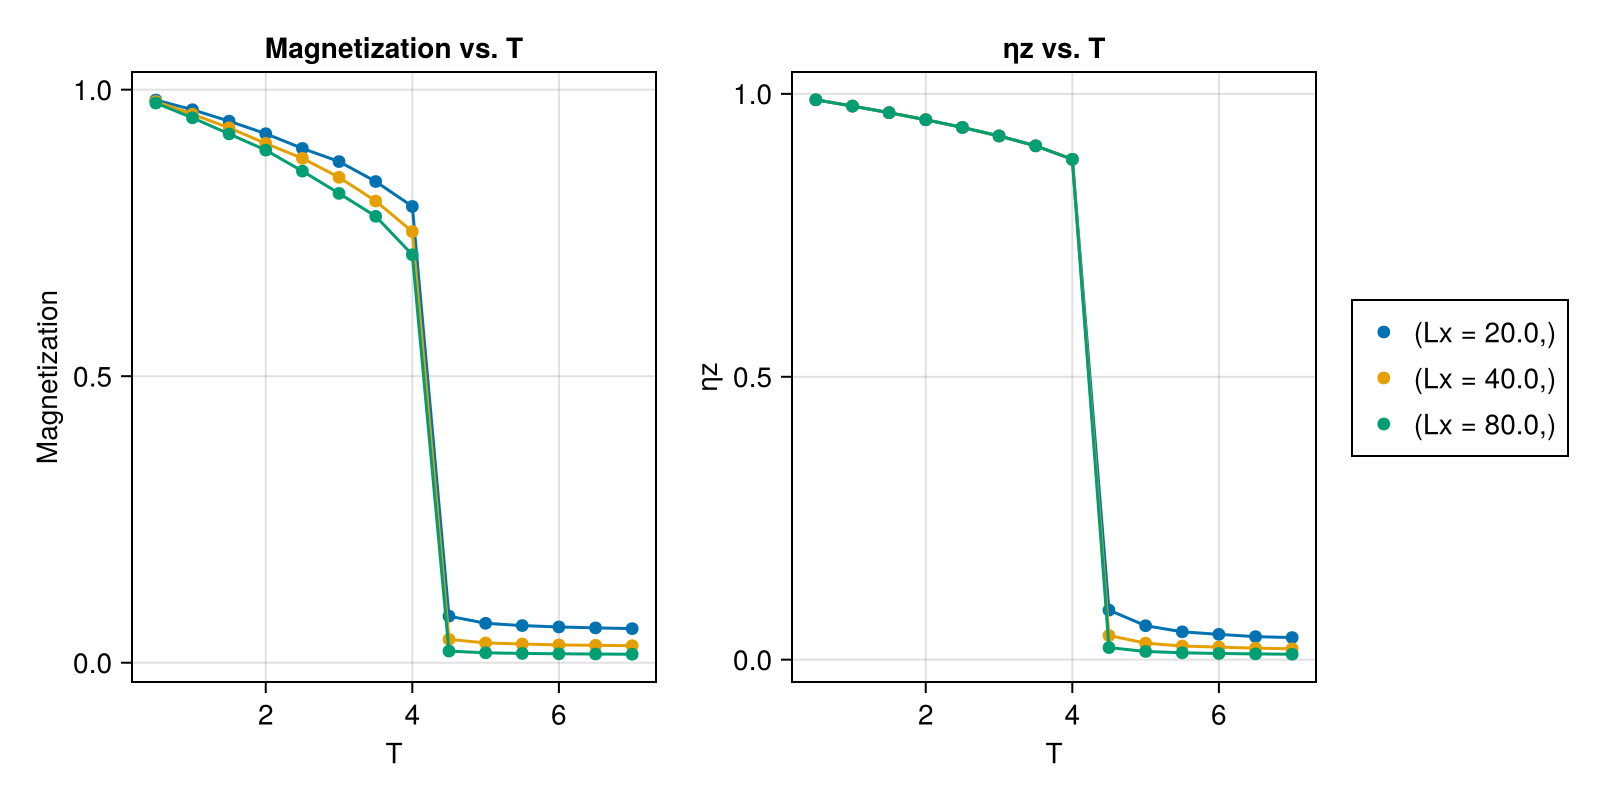

In [9]:
CairoMakie.activate!()

fig = Figure(size=(800, 400))
ax1 = fig[1,1] = Axis(fig, title="Magnetization vs. T", xlabel="T", ylabel="Magnetization")
# scatter!(ax1, results[:B], M_points)
# lines!(ax1, results[:B], M_points)
generate_plot!(ax1, :T, :Mag, [:Lx], results.data; line=true)
fig[1,2] = ax2 = Axis(fig, title="ηz vs. T", xlabel="T", ylabel="ηz")
generate_plot!(ax2, :T, :ηz, [:Lx], results.data; line=true)
Legend(fig[1,3], ax2)
fig

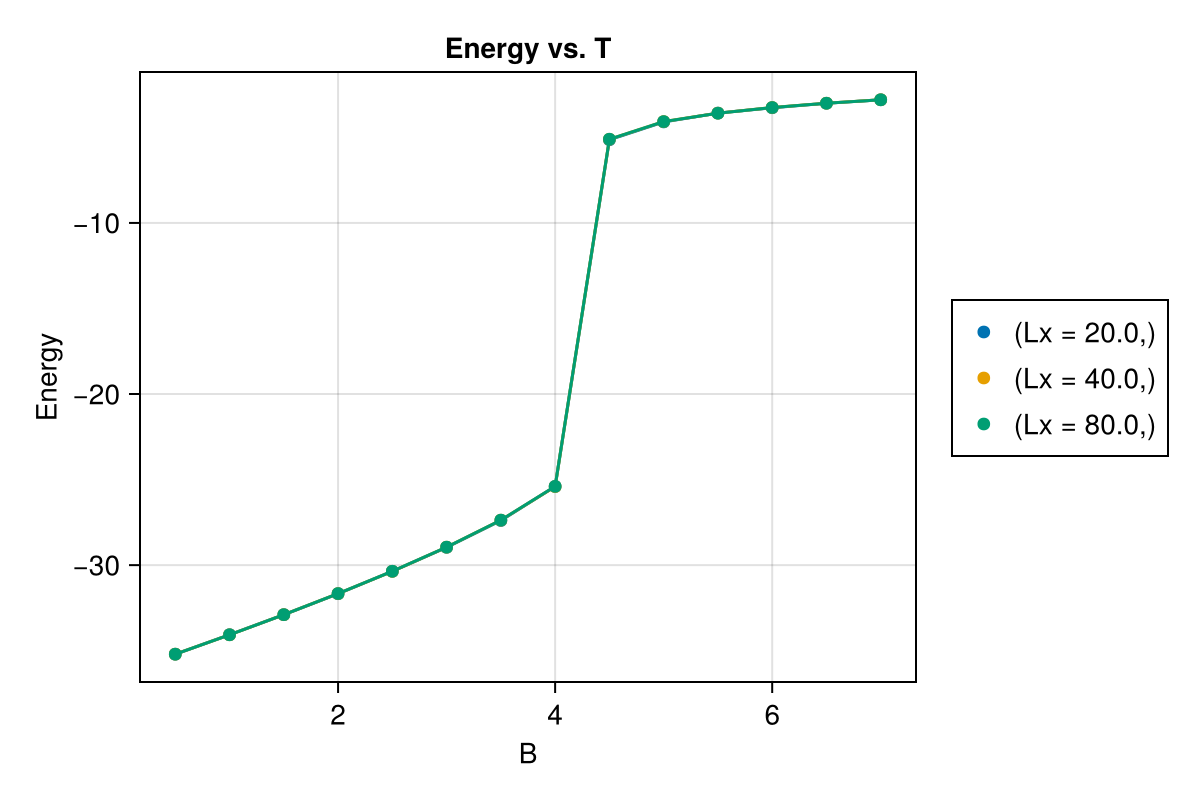

In [10]:
fig = Figure(size=(600, 400))
ax1 = fig[1,1] = Axis(fig, title="Energy vs. T", xlabel="B", ylabel="Energy")
# scatter!(ax1, bias_results[:B], M_points)
# lines!(ax1, bias_results[:B], M_points)
generate_plot!(ax1, :T, :Energy, [:Lx], results.data; line=true)
Legend(fig[1,2], ax1)
fig

In [11]:
mctimes = get_mctime_data(results, :etak_corrs, :ηz)
separate_etaks!.(mctimes)
mctimes

42-element Vector{DataFrame}:
 100×11 DataFrame
 Row │ etak_corrs                         ηz              ηk_xx                ⋯
     │ SubArray…                          SubArray…       Array…               ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ ComplexF64[2.74635e-5+0.0im 1.29…  fill(0.989505)  ComplexF64[2.74635e- ⋯
   2 │ ComplexF64[2.85874e-5+0.0im 2.03…  fill(0.988938)  ComplexF64[2.85874e-
   3 │ ComplexF64[2.4373e-5+0.0im 8.157…  fill(0.989858)  ComplexF64[2.4373e-5
   4 │ ComplexF64[1.85674e-5+0.0im 1.06…  fill(0.989618)  ComplexF64[1.85674e-
   5 │ ComplexF64[1.96137e-5+0.0im 1.42…  fill(0.989582)  ComplexF64[1.96137e- ⋯
   6 │ ComplexF64[1.50824e-5+0.0im 1.00…  fill(0.988948)  ComplexF64[1.50824e-
   7 │ ComplexF64[7.295e-6+0.0im 1.2153…  fill(0.989903)  ComplexF64[7.295e-6+
   8 │ ComplexF64[8.44951e-6+0.0im 1.50…  fill(0.990308)  ComplexF64[8.44951e-
  ⋮  │                 ⋮                        ⋮                        

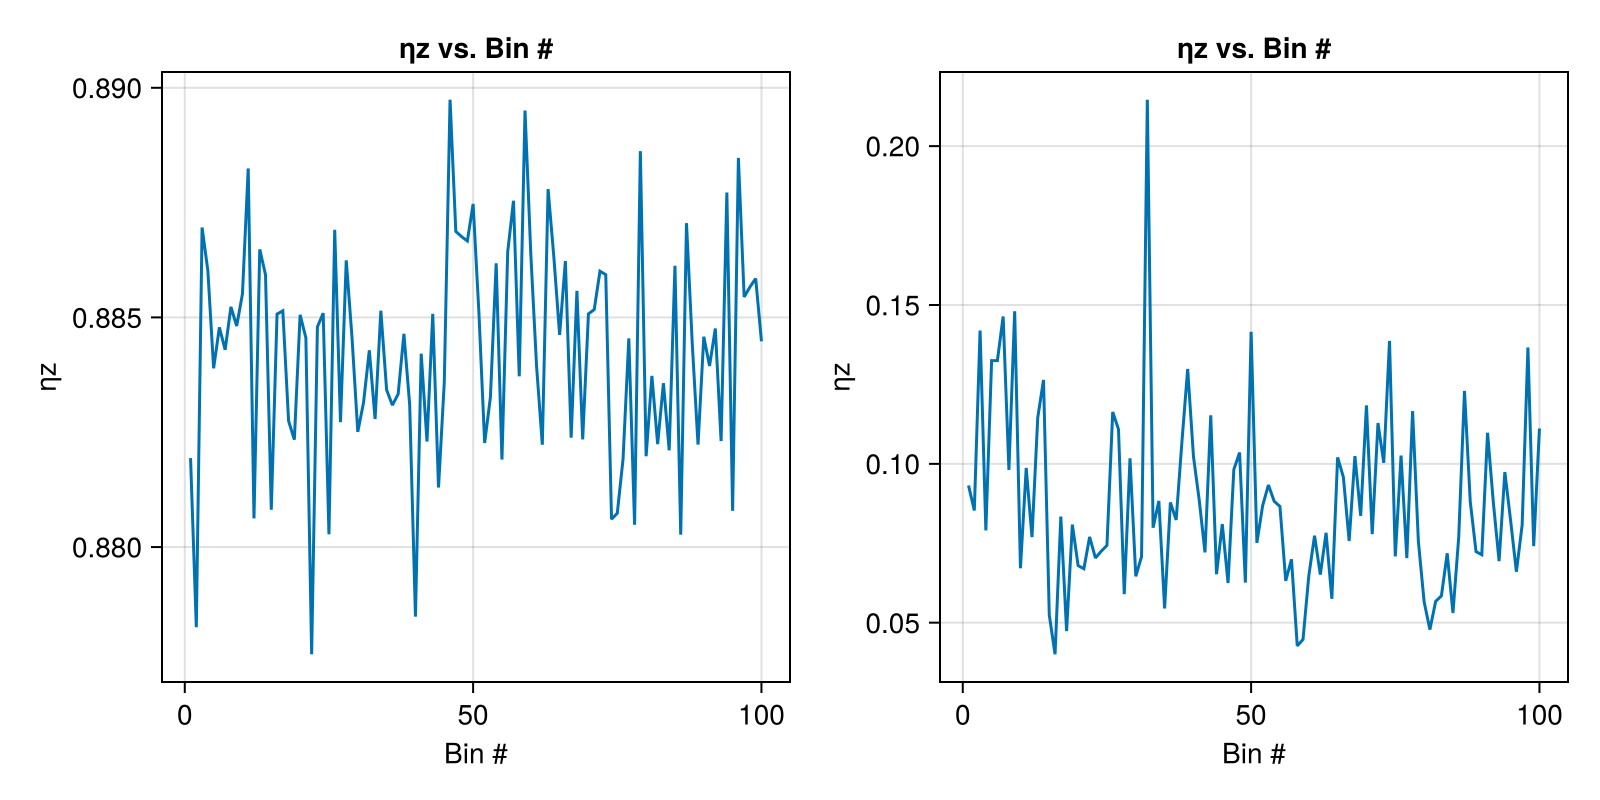

In [12]:
CairoMakie.activate!()
i = 8
k_pos = (1, 1)

var1 = :ηz
var2 = :ηz
fig = Figure(size=(800, 400))
fig[1,1] = ax1 = Axis(fig, title="$var1 vs. Bin #", xlabel="Bin #", ylabel="$var1")
fig[1,2] = ax2 = Axis(fig, title="$var2 vs. Bin #", xlabel="Bin #", ylabel="$var2")
lines!(ax1, abs.(first.(mctimes[i][:, var1])))
lines!(ax2, abs.(first.(mctimes[i+1][:, var2])))
fig

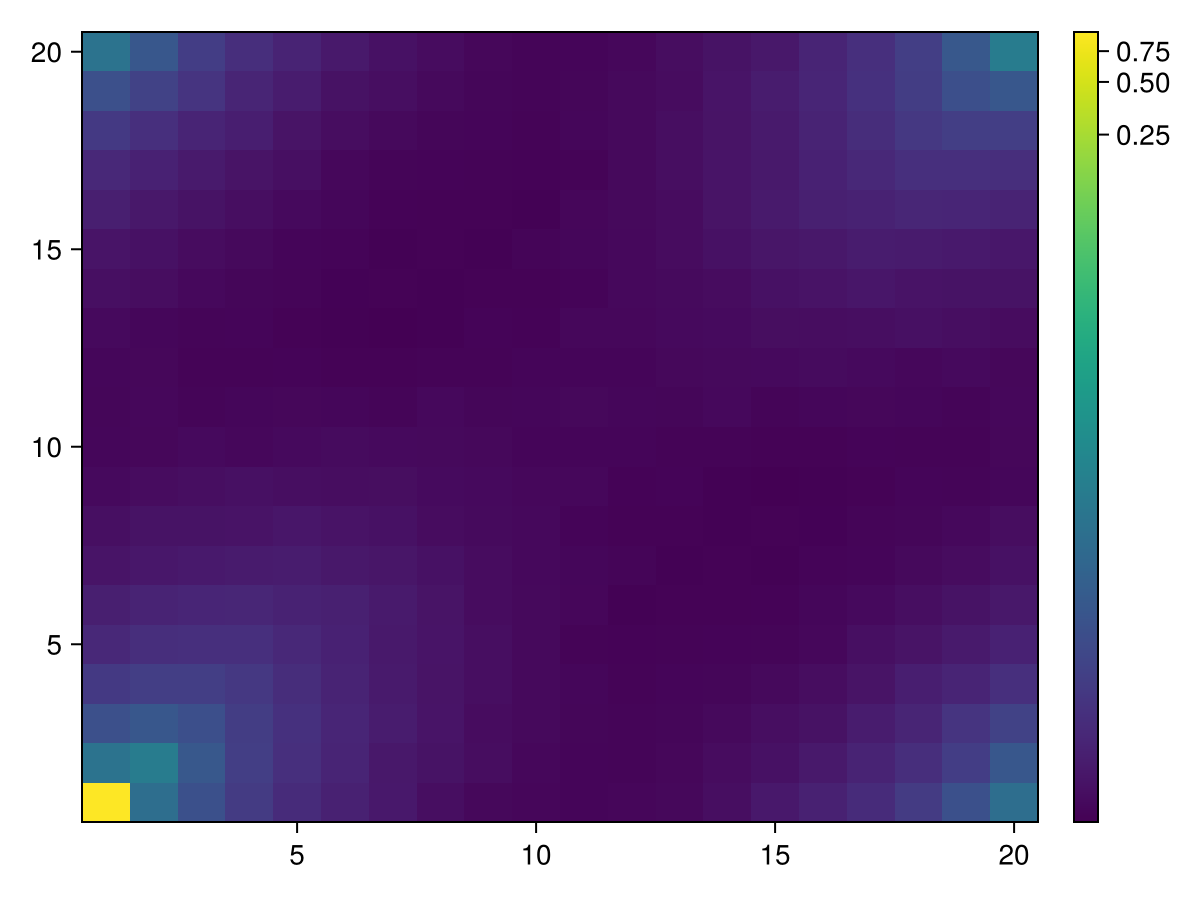

In [13]:
CairoMakie.activate!()
spink_corrs = results[:spink_corrs]
fig = Figure(size=(500, 500))
ax = fig[1,1] = Axis(fig; title="Spin_k")
scale = ReversibleScale(log)
fig, ax, hm = heatmap(getfield.(spink_corrs[1], :val), colorscale=scale)
Colorbar(fig[1, 2], hm)
fig

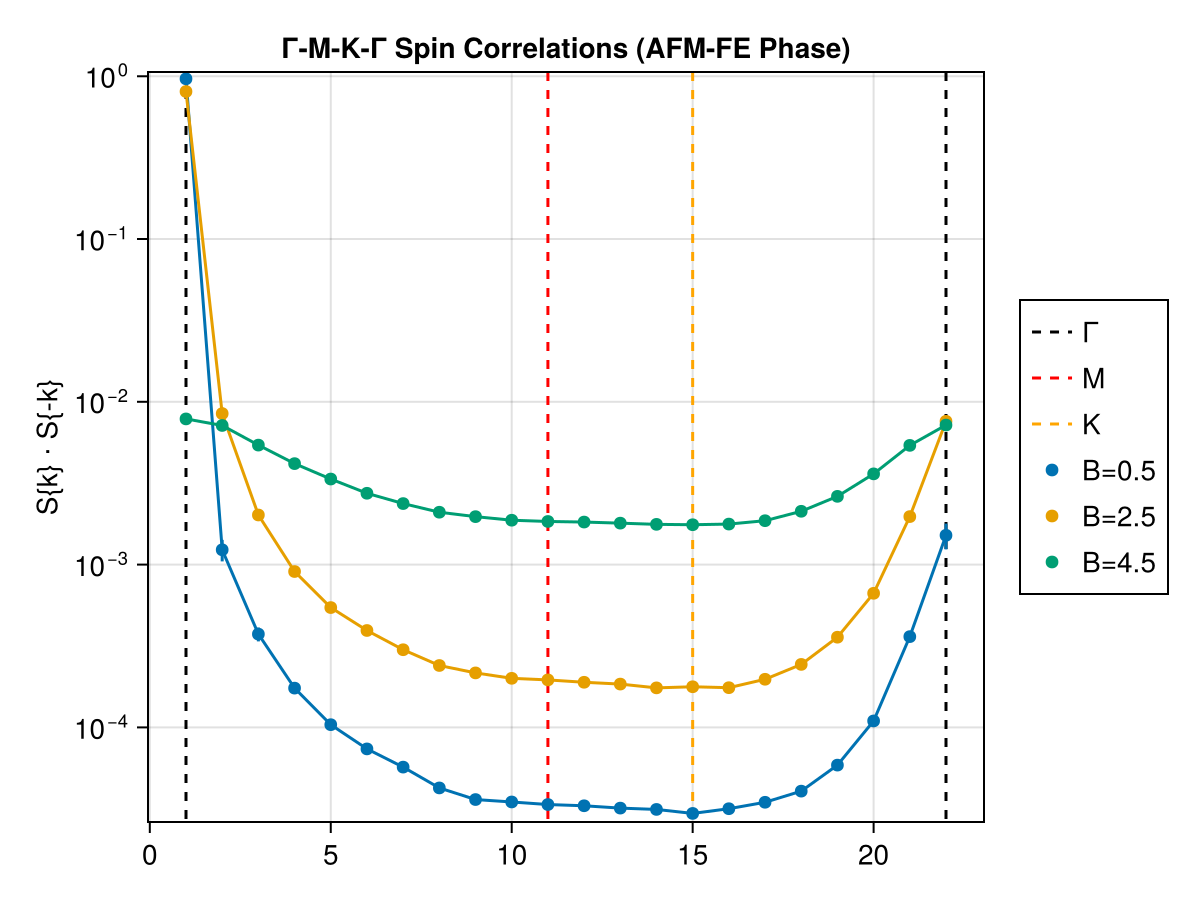

In [14]:
CairoMakie.activate!()
spink_corrs = results[:spink_corrs]
is = [1, 5, 9]

spink_corrs = results[:spink_corrs]
Bs = results[:T]
path, M_pos, K_pos = gen_path(size(spink_corrs[1])...)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (AFM-FE Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

all_corrs = [spink_corrs[i][I...] for I in path for i in is]
min_corr = minimum(getfield.(all_corrs, :val) - getfield.(all_corrs, :err))
min_border = 0.9 * min_corr
max_corr = maximum(getfield.(all_corrs, :val) + getfield.(all_corrs, :err))
max_border = 1.1 * max_corr
lines!([(1, max_border), (1, min_border)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, max_border), (M_pos, min_border)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, max_border), (K_pos, min_border)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), max_border), (length(path), min_border)], color=:black, linestyle=:dash)

for i in is
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs, label="B=$(Bs[i])")
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (min_border, max_border))
Legend(fig[1,2], ax)
fig

Any[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (19, 10), (17, 9), (15, 8), (13, 7), (14, 6), (15, 5), (16, 4), (17, 3), (18, 2), (19, 1)]


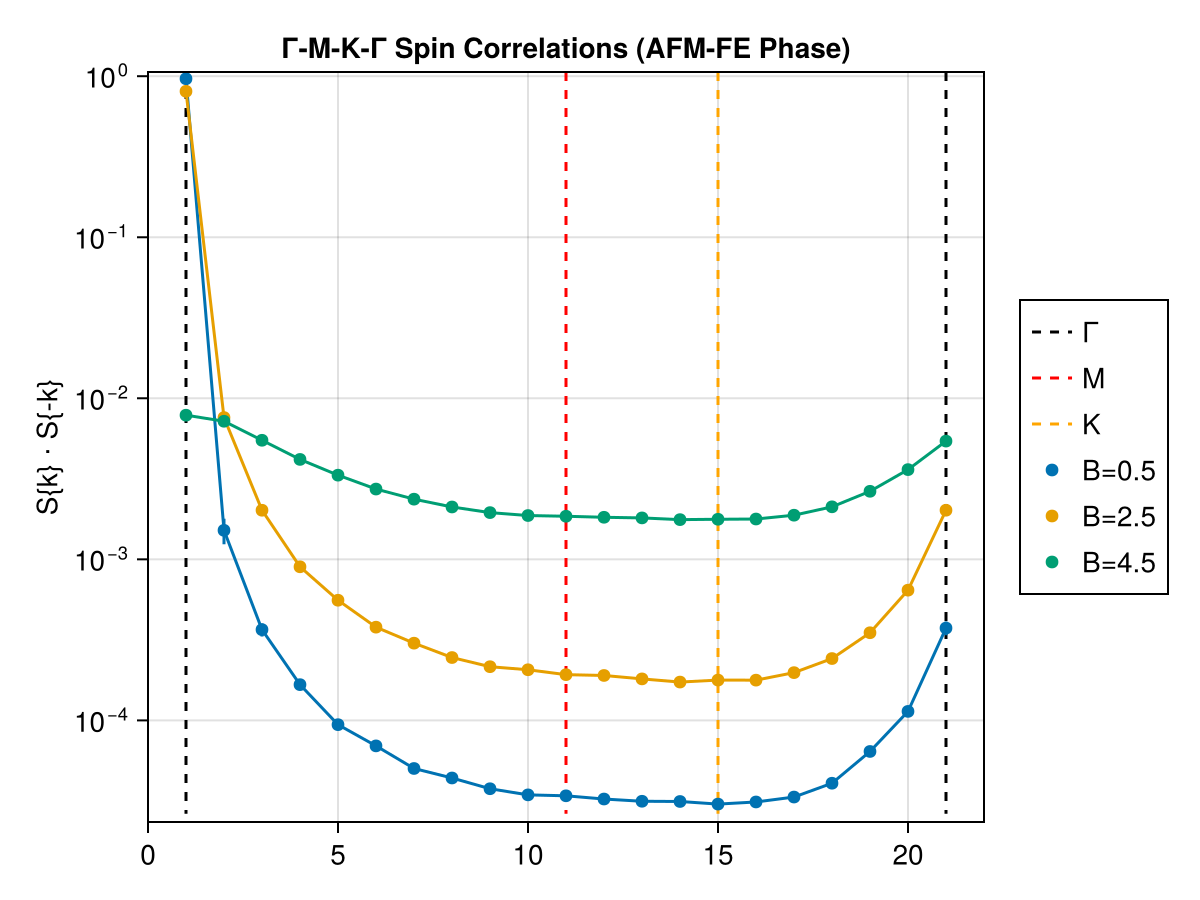

In [15]:
CairoMakie.activate!()
Lx, Ly = size(spink_corrs[1])

path = []
pos = (1, 1)
push!(path, pos)
while pos[2] < div(Ly, 2) + 1
    pos = pos .+ (0, 1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
M_pos = length(path)
while pos[2] > div(Ly, 3) + 1
    pos = pos .+ (-2, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
K_pos = length(path)
while pos[2] > 1
    pos = pos .+ (1, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
println(path)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (AFM-FE Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

all_corrs = [spink_corrs[i][I...] for I in path for i in is]
min_corr = minimum(getfield.(all_corrs, :val) - getfield.(all_corrs, :err))
min_border = 0.9 * min_corr
max_corr = maximum(getfield.(all_corrs, :val) + getfield.(all_corrs, :err))
max_border = 1.1 * max_corr
lines!([(1, max_border), (1, min_border)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, max_border), (M_pos, min_border)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, max_border), (K_pos, min_border)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), max_border), (length(path), min_border)], color=:black, linestyle=:dash)

for i in is
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs, label="B=$(Bs[i])")
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (0.8 * min_corr, 1.1 * max_corr))
Legend(fig[1,2], ax)
fig

Any[(1, 1), (20, 20), (19, 19), (18, 18), (17, 17), (16, 16), (15, 15), (14, 14), (13, 13), (12, 12), (11, 11), (12, 10), (13, 9), (14, 8), (15, 7), (16, 9), (17, 11), (18, 13), (19, 15), (20, 17), (1, 19), (2, 1)]


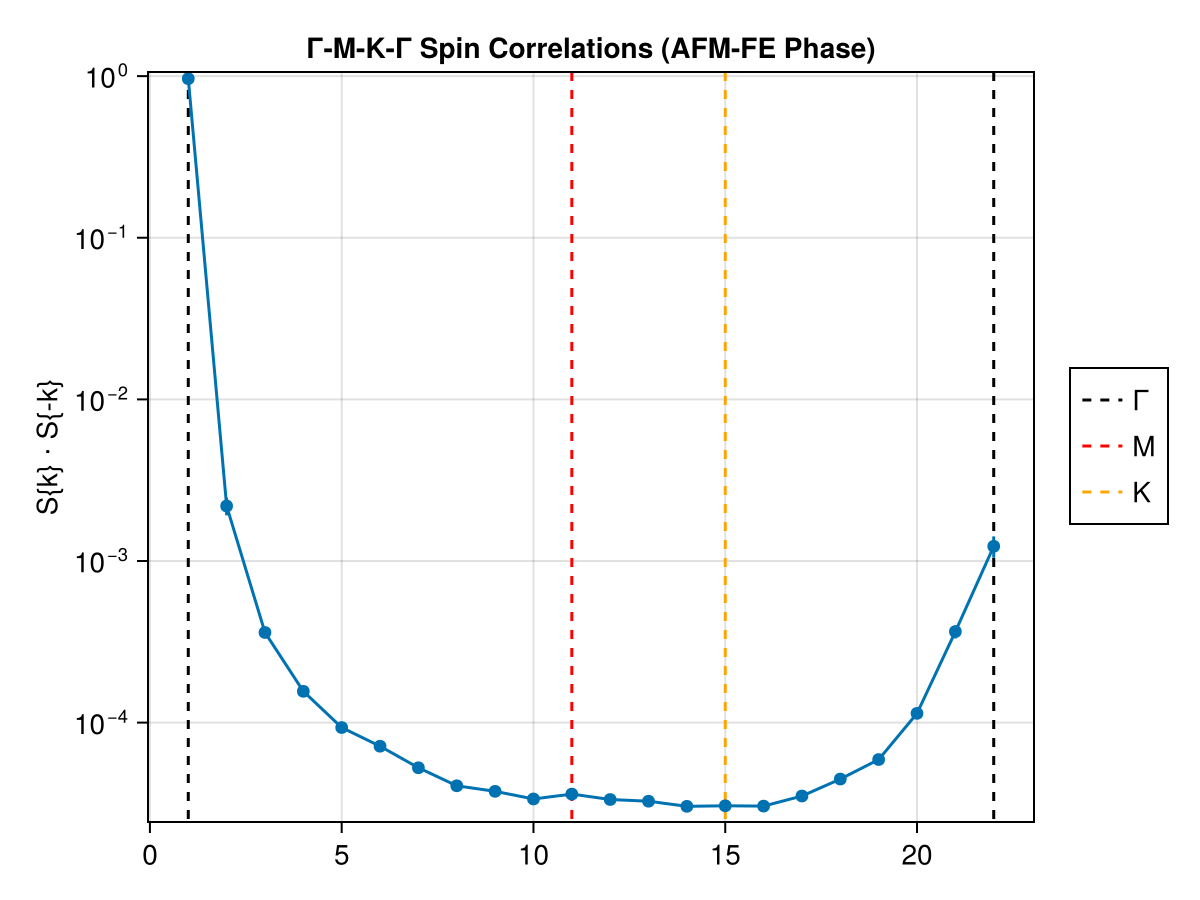

In [16]:
CairoMakie.activate!()
Lx, Ly = size(spink_corrs[1])

path = []
pos = (1, 1)
push!(path, pos)
while pos[2] > -div(Ly, 2) + 1
    pos = pos .+ (-1, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
M_pos = length(path)
while pos[1] < -div(Lx, 3) + 1
    pos = pos .+ (1, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
K_pos = length(path)
while pos[2] < 1
    pos = pos .+ (1, 2)
    push!(path, mod1.(pos, (Lx, Ly)))
end
println(path)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (AFM-FE Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

min_corr = minimum(getfield.([spink_corrs[1][I...] for I in path], :val))
max_corr = maximum(getfield.([spink_corrs[1][I...] for I in path], :val))
lines!([(1, 2), (1, 1e-9)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, 2), (M_pos, 1e-9)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, 2), (K_pos, 1e-9)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), 2), (length(path), 1e-9)], color=:black, linestyle=:dash)

for i in [1]
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs)
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (0.8 * min_corr, 1.1 * max_corr))
Legend(fig[1,2], ax)
fig

In [17]:
CairoMakie.activate!()

i = 7
Lx = 40
etak_corrs = bias_results[:etak_corrs]
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
scale = ReversibleScale(log)
corr_matrices = eachslice(etak_corrs[i], dims=(1, 2))
max_corrs = maximum(abs.(etak_corrs[i]))
min_corrs = minimum(abs.(etak_corrs[i]))
for x in 1:3
    for y in 1:3
        fig[x, y] = ax = Axis(fig, title="$(labels[x])$(labels[y])")
        corrs = getindex.(corr_matrices, x, y)
        heatmap!(ax, getfield.(abs.(corrs), :val), colorrange=(0, max_corrs.val))
        hidedecorations!(ax)
    end
end

print("Maximum correlation norm: $max_corrs")
fig

UndefVarError: UndefVarError: `bias_results` not defined

In [18]:
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
Bs = bias_results[:B]
scale = ReversibleScale(log)

axs = Matrix{Axis}(undef, 3, 3)
for x in 1:3
    for y in 1:3
        fig[x, y] = axs[x, y] = Axis(fig, title="$(labels[x])$(labels[y])")
    end
end

is = [1, 5, 9]
for (x, y) in Iterators.product(1:3, 1:3)
    ax = axs[x, y]

    corr_matrices = bias_results["ηk_$(labels[x])$(labels[y])"]
    path, M_pos, K_pos = gen_path(size(corr_matrices[first(is)])...)
    all_corrs = [abs(corr_matrices[i][I...]) for I in path for i in is]
    min_corr = minimum(getfield.(all_corrs, :val) - getfield.(all_corrs, :err))
    min_border = 0.9 * min_corr
    max_corr = maximum(getfield.(all_corrs, :val) + getfield.(all_corrs, :err))
    max_border = 1.1 * max_corr
    lines!(
        ax, [(1, max_border), (1, min_border)],
        color=:black, label="Γ", linestyle=:dash
    )
    lines!(
        ax, [(M_pos, max_border), (M_pos, min_border)],
        color=:red, label="M", linestyle=:dash
    )
    lines!(
        ax, [(K_pos, max_border), (K_pos, min_border)],
        color=:orange, label="K", linestyle=:dash
    )

    for i in is
        corr_matrix = corr_matrices[i]
        corrs = [corr_matrix[I...] for I in path]
        corr_vals = getfield.(abs.(corrs), :val)
        corr_errs = getfield.(abs.(corrs), :err)
        scatter!(ax, corr_vals, label="B=$(Bs[i])")
        lines!(ax, corr_vals)
        errorbars!(ax, 1:length(corr_vals), corr_vals, corr_errs)
    end
    ylims!(ax, (min_border, max_border))
end

Legend(fig[:, 4], axs[1, 1])
fig

UndefVarError: UndefVarError: `bias_results` not defined

## Annealed Random Initial State

In [62]:
anneal_results = JobResult("../jobs", "fm-anneal")
separate_etaks!(anneal_results.data)
anneal_results

JobResult("../jobs", "fm-anneal", 42×35 DataFrame
 Row │ ηz               T        init_T   etak_corrs                         _ ⋯
     │ Measurem…        Float64  Float64  Array…                             M ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.989587±5.6e-5      0.5     10.0  Complex{Measurement{Float64}}[1.…  0 ⋯
   2 │ 0.978503±5.6e-5      1.0     10.0  Complex{Measurement{Float64}}[3.…  0
   3 │ 0.966843±5.4e-5      1.5     10.0  Complex{Measurement{Float64}}[5.…  0
   4 │ 0.954295±9.4e-5      2.0     10.0  Complex{Measurement{Float64}}[6.…  0
   5 │ 0.9407±0.00012       2.5     10.0  Complex{Measurement{Float64}}[8.…  0 ⋯
   6 │ 0.92542±0.00012      3.0     10.0  Complex{Measurement{Float64}}[0.…  0
   7 │ 0.90818±0.0002       3.5     10.0  Complex{Measurement{Float64}}[0.…  0
   8 │ 0.88491±0.00021      4.0     10.0  Complex{Measurement{Float64}}[0.…  0
  ⋮  │        ⋮            ⋮        ⋮                     ⋮            

In [63]:
anneal_results[[:_ll_sweep_time, :_ll_measure_time]]

42×2 DataFrame
 Row │ _ll_sweep_time    _ll_measure_time 
     │ Measurement…      Measurement…     
─────┼────────────────────────────────────
   1 │ 0.0003411±1.3e-6  0.0001155±7.0e-6
   2 │ 0.0003376±1.3e-6  0.000116±7.0e-6
   3 │ 0.0003417±1.2e-6  0.0001166±6.9e-6
   4 │ 0.0003381±1.2e-6  0.0001165±6.8e-6
   5 │ 0.0003461±2.7e-6  0.0001173±6.9e-6
   6 │ 0.0003398±1.1e-6  0.0001169±6.8e-6
   7 │ 0.0003417±3.1e-6  0.0001166±6.8e-6
   8 │ 0.0003399±1.2e-6  0.0001158±7.0e-6
  ⋮  │        ⋮                 ⋮
  36 │ 0.005544±1.1e-5   0.0014084±2.6e-6
  37 │ 0.0057119±9.4e-6  0.0014062±2.8e-6
  38 │ 0.005678±1.1e-5   0.0014205±4.8e-6
  39 │ 0.005697±1.2e-5   0.0014177±4.0e-6
  40 │ 0.005759±1.3e-5   0.0014229±4.9e-6
  41 │ 0.005771±1.1e-5   0.0014199±4.1e-6
  42 │ 0.0057082±7.3e-6  0.001419±2.7e-6
                           27 rows omitted

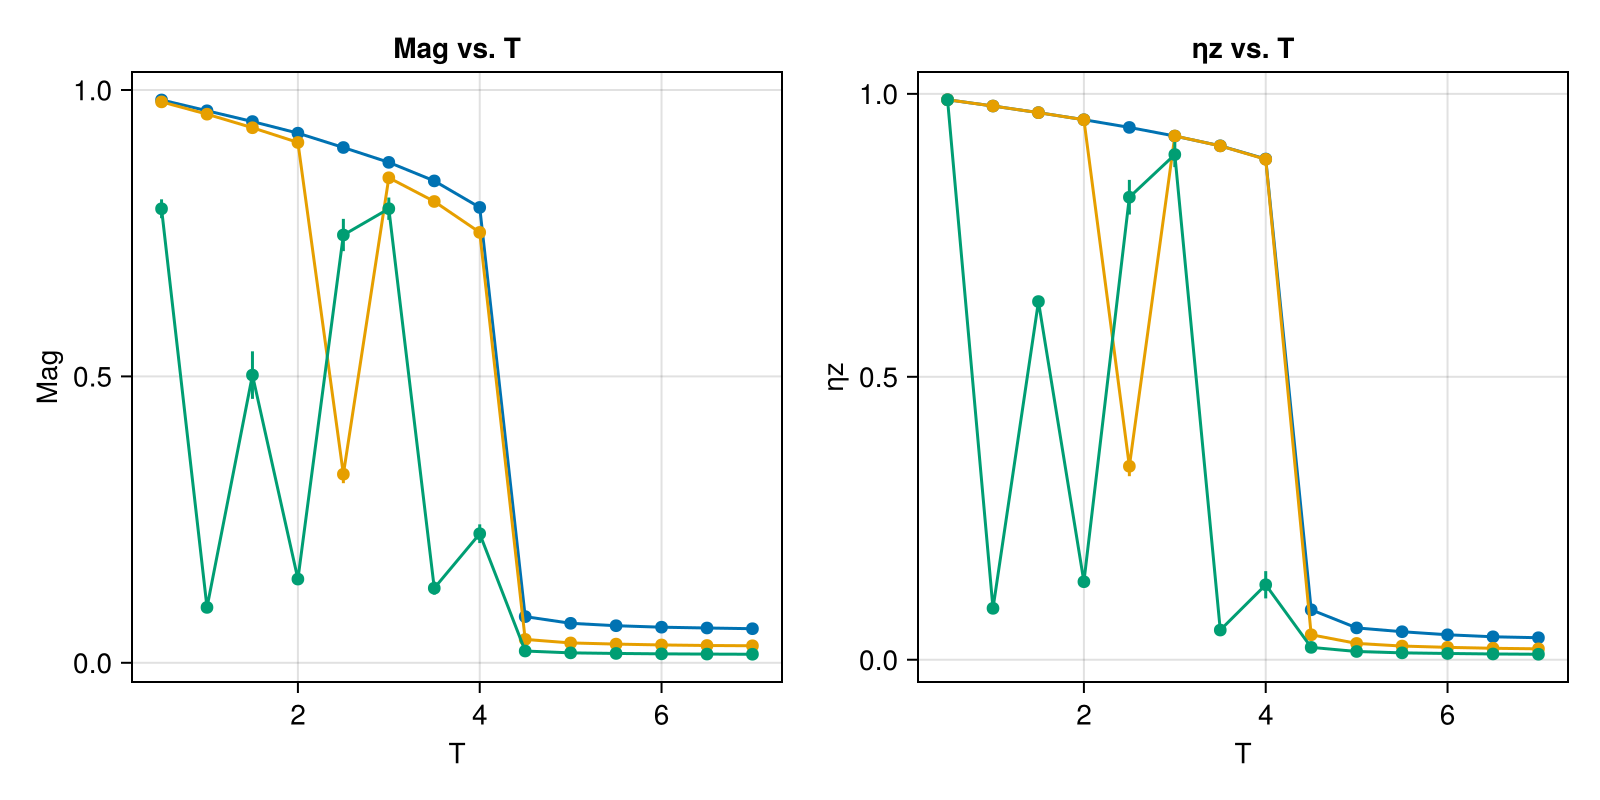

In [64]:
CairoMakie.activate!()

fig = Figure(size=(800, 400))
gd = groupby(anneal_results.data, :Lx)
fig[1,1] = ax_s = Axis(fig, title="Mag vs. T", xlabel="T", ylabel="Mag")
generate_plot!(ax_s, :T, :Mag, gd; line=true)
fig[1,2] = ax_η = Axis(fig, title="ηz vs. T", xlabel="T", ylabel="ηz")
generate_plot!(ax_η, :T, :ηz, gd; line=true)
fig

In [65]:
anneal_mctimes = get_mctime_data(anneal_results, :Mag, :Magx, :Magy, :Magz, :ηz)

42-element Vector{DataFrame}:
 100×5 DataFrame
 Row │ Mag             Magx            Magy              Magz            ηz    ⋯
     │ SubArray…       SubArray…       SubArray…         SubArray…       SubAr ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ fill(0.978818)  fill(0.41902)   fill(-0.12398)    fill(0.875826)  fill( ⋯
   2 │ fill(0.980117)  fill(0.408161)  fill(-0.112903)   fill(0.883864)  fill(
   3 │ fill(0.981638)  fill(0.417909)  fill(-0.120119)   fill(0.880056)  fill(
   4 │ fill(0.978308)  fill(0.422508)  fill(-0.100673)   fill(0.876525)  fill(
   5 │ fill(0.979636)  fill(0.425302)  fill(-0.0906895)  fill(0.87777)   fill( ⋯
   6 │ fill(0.980443)  fill(0.425656)  fill(-0.0938976)  fill(0.878177)  fill(
   7 │ fill(0.980423)  fill(0.426709)  fill(-0.0778931)  fill(0.879157)  fill(
   8 │ fill(0.98256)   fill(0.45112)   fill(-0.0577651)  fill(0.870895)  fill(
  ⋮  │       ⋮               ⋮                ⋮                ⋮          

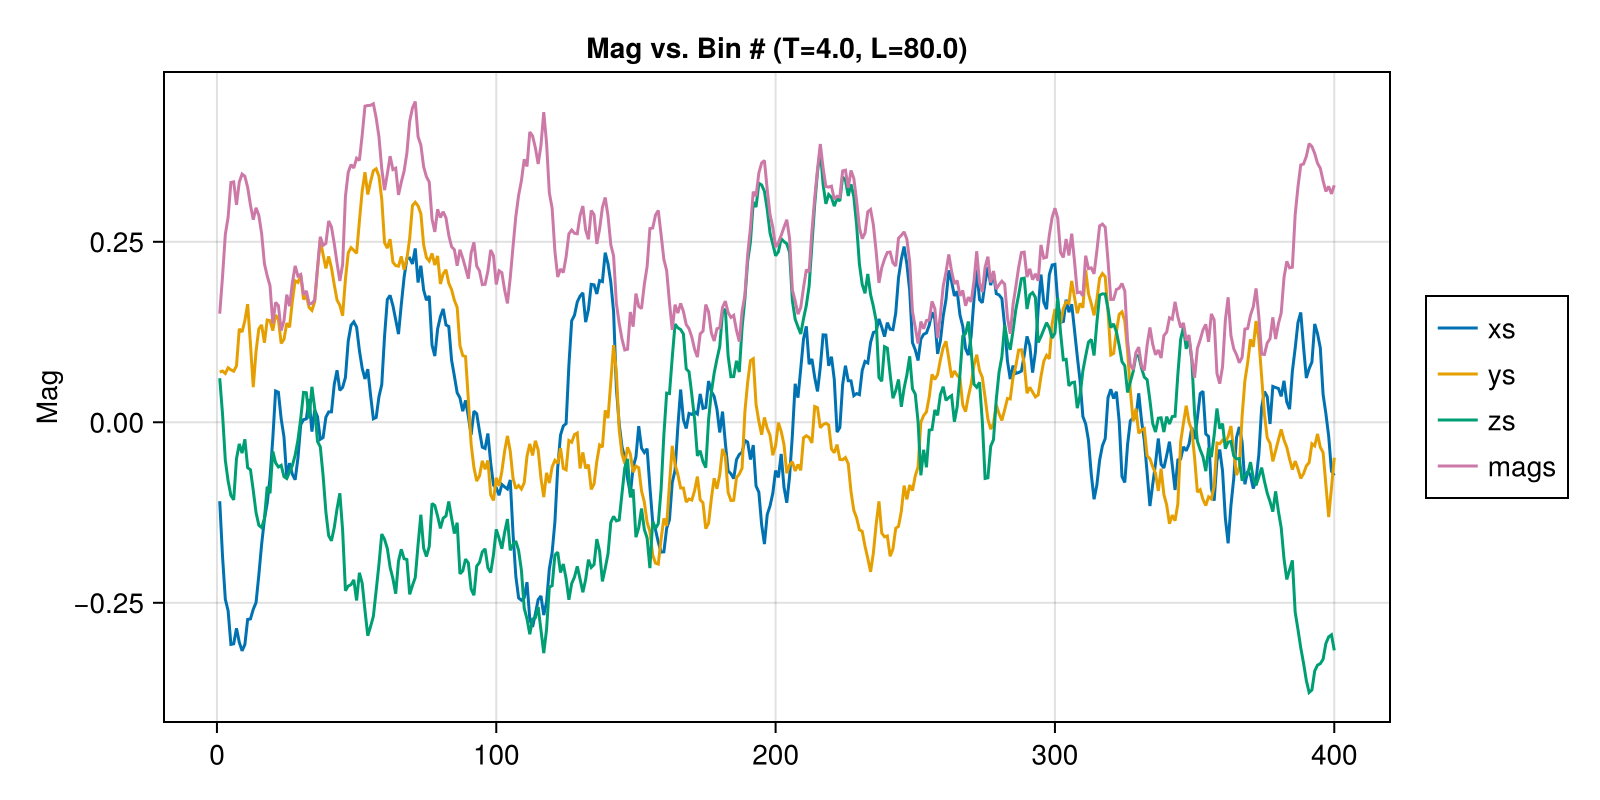

In [66]:
i = 36
mctimes = anneal_mctimes[i][:, [:Mag, :Magx, :Magy, :Magz]]

fig = Figure(size=(800, 400))
ax1 = fig[1,1] = Axis(
    fig,
    title="Mag vs. Bin # (T=$(anneal_results.data[i, :T]), L=$(anneal_results.data[i, :Lx]))",
    ylabel="Mag"
)
mags = first.(mctimes[:, :Mag])
xs = first.(mctimes[:, :Magx])
ys = first.(mctimes[:, :Magy])
zs = first.(mctimes[:, :Magz])
lines!(ax1, xs, label="xs")
lines!(ax1, ys, label="ys")
lines!(ax1, zs, label="zs")
lines!(ax1, mags, label="mags")
Legend(fig[1,2], ax1)
fig

In [67]:
spink_corrs = anneal_results[:spink_corrs]

42-element Vector{Matrix{Measurements.Measurement{Float64}}}:
 [0.96558 ± 0.00079 0.00161 ± 0.00019 … 0.000357 ± 1.9e-5 0.00161 ± 0.00019; 0.00151 ± 0.00015 0.00127 ± 0.00018 … 0.000221 ± 1.1e-5 0.000456 ± 4.7e-5; … ; 0.000344 ± 2.4e-5 0.0002081 ± 7.6e-6 … 0.000385 ± 2.4e-5 0.000509 ± 4.5e-5; 0.00151 ± 0.00015 0.000456 ± 4.7e-5 … 0.000463 ± 3.6e-5 0.00127 ± 0.00018]
 [0.9288 ± 0.0014 0.00294 ± 0.00032 … 0.000707 ± 3.6e-5 0.00294 ± 0.00032; 0.00337 ± 0.00034 0.00313 ± 0.00048 … 0.000415 ± 1.2e-5 0.000956 ± 5.8e-5; … ; 0.000693 ± 4.1e-5 0.000429 ± 2.3e-5 … 0.000754 ± 3.4e-5 0.000793 ± 3.4e-5; 0.00337 ± 0.00034 0.000956 ± 5.8e-5 … 0.00098 ± 6.7e-5 0.00313 ± 0.00048]
 [0.8929 ± 0.0015 0.00434 ± 0.00035 … 0.001072 ± 4.4e-5 0.00434 ± 0.00035; 0.00405 ± 0.00038 0.00448 ± 0.00055 … 0.000673 ± 2.3e-5 0.001375 ± 7.9e-5; … ; 0.001083 ± 4.2e-5 0.000611 ± 1.9e-5 … 0.001067 ± 4.8e-5 0.001584 ± 6.1e-5; 0.00405 ± 0.00038 0.001375 ± 7.9e-5 … 0.001479 ± 7.0e-5 0.00448 ± 0.00055]
 [0.8551 ± 0.0013 0.0049

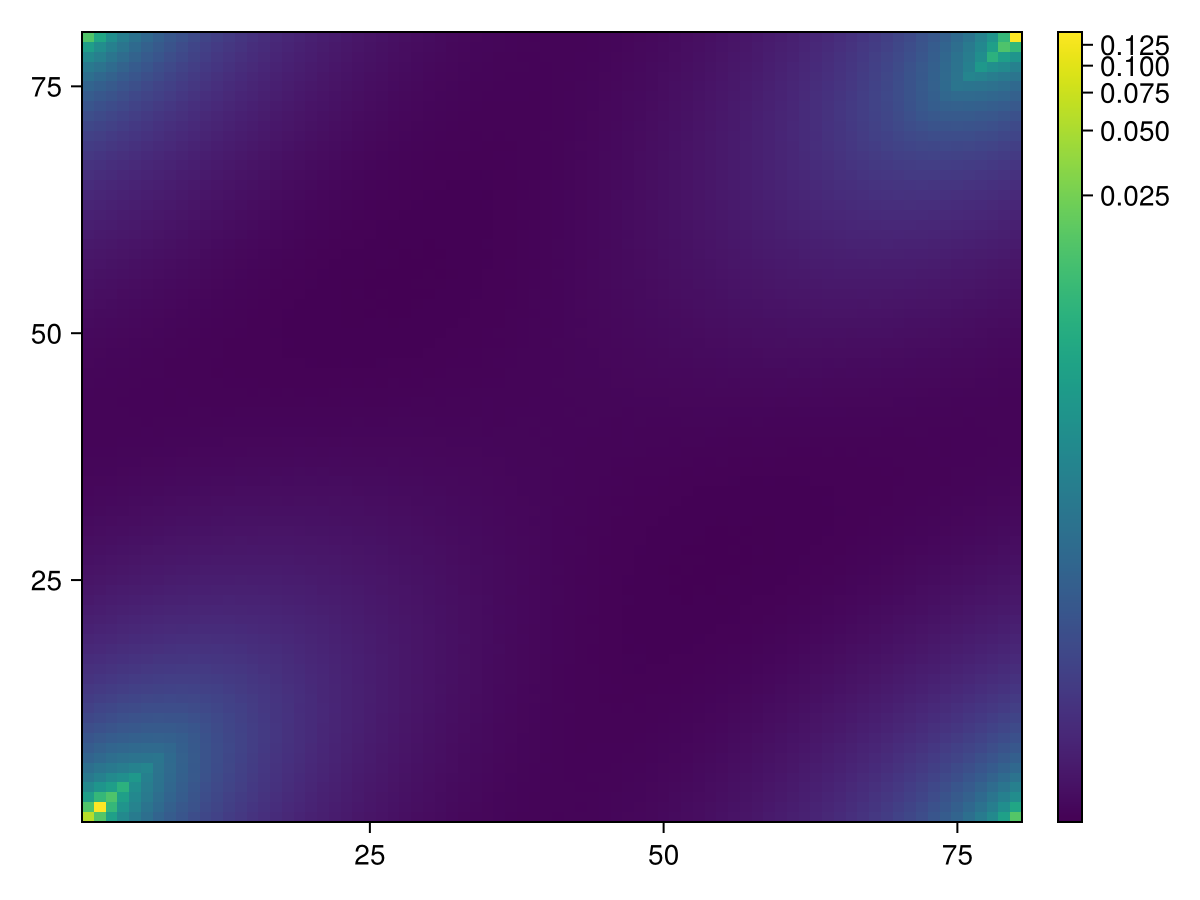

In [68]:
CairoMakie.activate!()
fig = Figure(size=(500, 500))
ax = fig[1,1] = Axis(fig; title="Spin_k")
scale = ReversibleScale(log)
fig, ax, hm = heatmap(getfield.(spink_corrs[36], :val), colorscale=scale)
Colorbar(fig[1, 2], hm)
fig

Any[(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 3), (12, 5), (13, 7), (11, 6), (9, 5), (7, 4), (5, 3), (3, 2), (1, 1)]


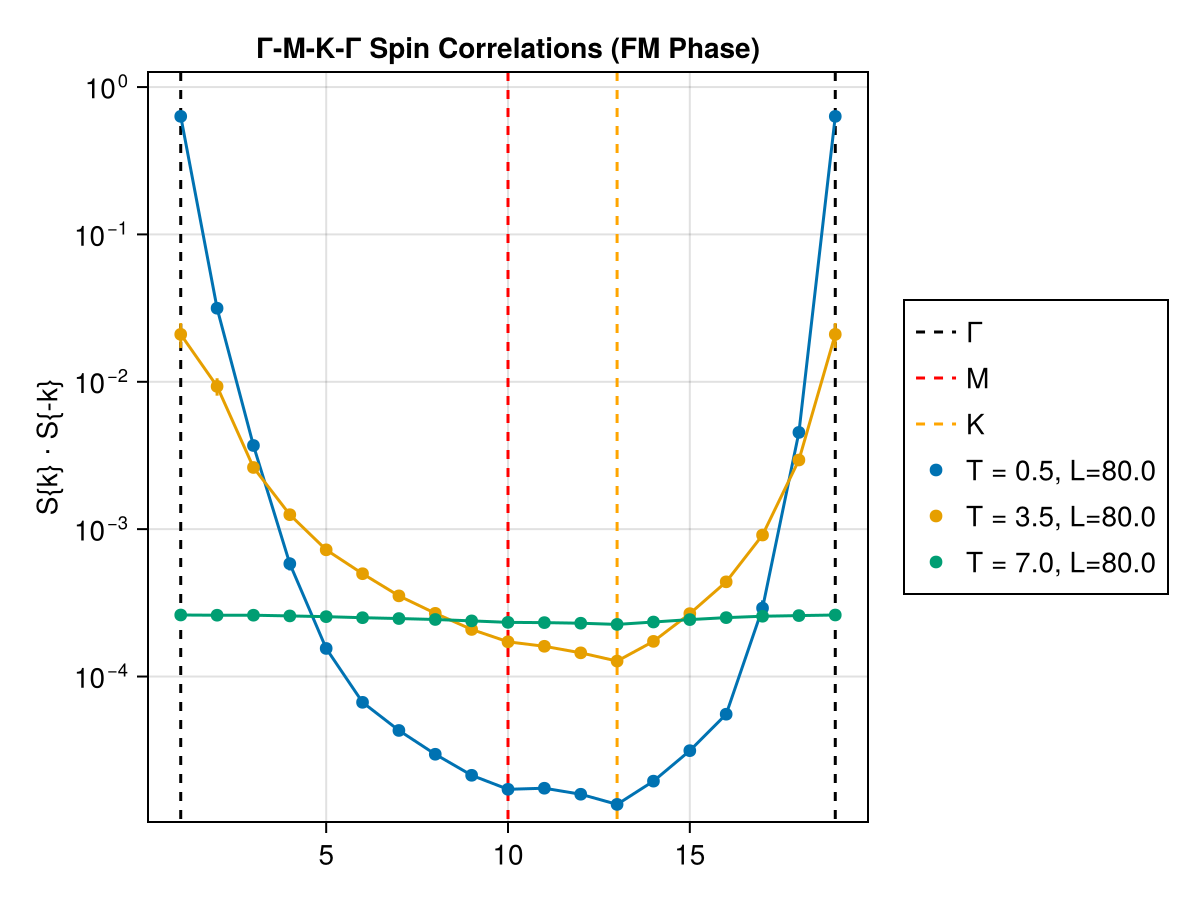

In [69]:
CairoMakie.activate!()
Lx, Ly = size(spink_corrs[1])
borderx = div(Lx, 2) + 1
bordery = div(Ly, 2) + 1

path = []
pos = (1, 1)
push!(path, pos)
while pos[1] < div(Lx, 2)
    pos = pos .+ (1, 0)
    push!(path, pos)
end
M_pos = length(path)
while pos[2] < div(Ly, 3)
    pos = pos .+ (1, 2)
    push!(path, pos)
end
K_pos = length(path)
while pos[2] > 1
    pos = pos .- (2, 1)
    push!(path, pos)
end
println(path)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (FM Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

min_corr = minimum(getfield.([spink_corrs[1][I...] for I in path], :val))
max_corr = maximum(getfield.([spink_corrs[1][I...] for I in path], :val))
lines!([(1, 2), (1, 1e-9)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, 2), (M_pos, 1e-9)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, 2), (K_pos, 1e-9)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), 2), (length(path), 1e-9)], color=:black, linestyle=:dash)
for i in [29, 35, 42]
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs, label="T = $(anneal_results.data[i, :T]), L=$(anneal_results.data[i, :Lx])")
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (min_corr - 2e-5, max_corr + 0.3))
Legend(fig[1,2], ax)
fig

In [70]:
etak_corrs = anneal_results[:etak_corrs]

42-element Vector{Array{Complex{Measurements.Measurement{Float64}}, 4}}:
 [1.621e-5 ± 9.0e-7 + 0.0 ± 0.0im 1.644e-5 ± 3.8e-7 + 0.0 ± 0.0im … 1.747e-5 ± 5.0e-7 + 0.0 ± 0.0im 1.644e-5 ± 3.8e-7 + 0.0 ± 0.0im; 1.664e-5 ± 4.5e-7 + 0.0 ± 0.0im 1.678e-5 ± 5.9e-7 + 0.0 ± 0.0im … 1.756e-5 ± 4.6e-7 + 0.0 ± 0.0im 1.582e-5 ± 5.4e-7 + 0.0 ± 0.0im; … ; 1.699e-5 ± 5.5e-7 + 0.0 ± 0.0im 1.748e-5 ± 5.7e-7 + 0.0 ± 0.0im … 1.647e-5 ± 5.1e-7 + 0.0 ± 0.0im 1.651e-5 ± 3.3e-7 + 0.0 ± 0.0im; 1.664e-5 ± 4.5e-7 + 0.0 ± 0.0im 1.582e-5 ± 5.4e-7 + 0.0 ± 0.0im … 1.65e-5 ± 4.6e-7 + 0.0 ± 0.0im 1.678e-5 ± 5.9e-7 + 0.0 ± 0.0im;;; -6.4e-7 ± 3.6e-7 + 0.0 ± 0.0im 5.0e-7 ± 5.8e-7 - 1.3240690665023628e-7 ± 0.0im … 3.4e-7 ± 5.5e-7 + 2.3410845474276833e-7 ± 0.0im 5.0e-7 ± 5.8e-7 + 1.3240690665023628e-7 ± 0.0im; -2.2e-7 ± 5.5e-7 + 5.6387526600852055e-8 ± 0.0im -1.7e-8 ± 4.6e-7 - 2.074926637593979e-7 ± 0.0im … -4.1e-7 ± 6.8e-7 - 5.052026347336811e-8 ± 0.0im 5.7e-7 ± 5.2e-7 + 1.7692671736338435e-7 ± 0.0im; … ; -5.4e-7 ± 4.9e-7 -

Maximum correlation norm: 0.307923 ± 2.6e-5

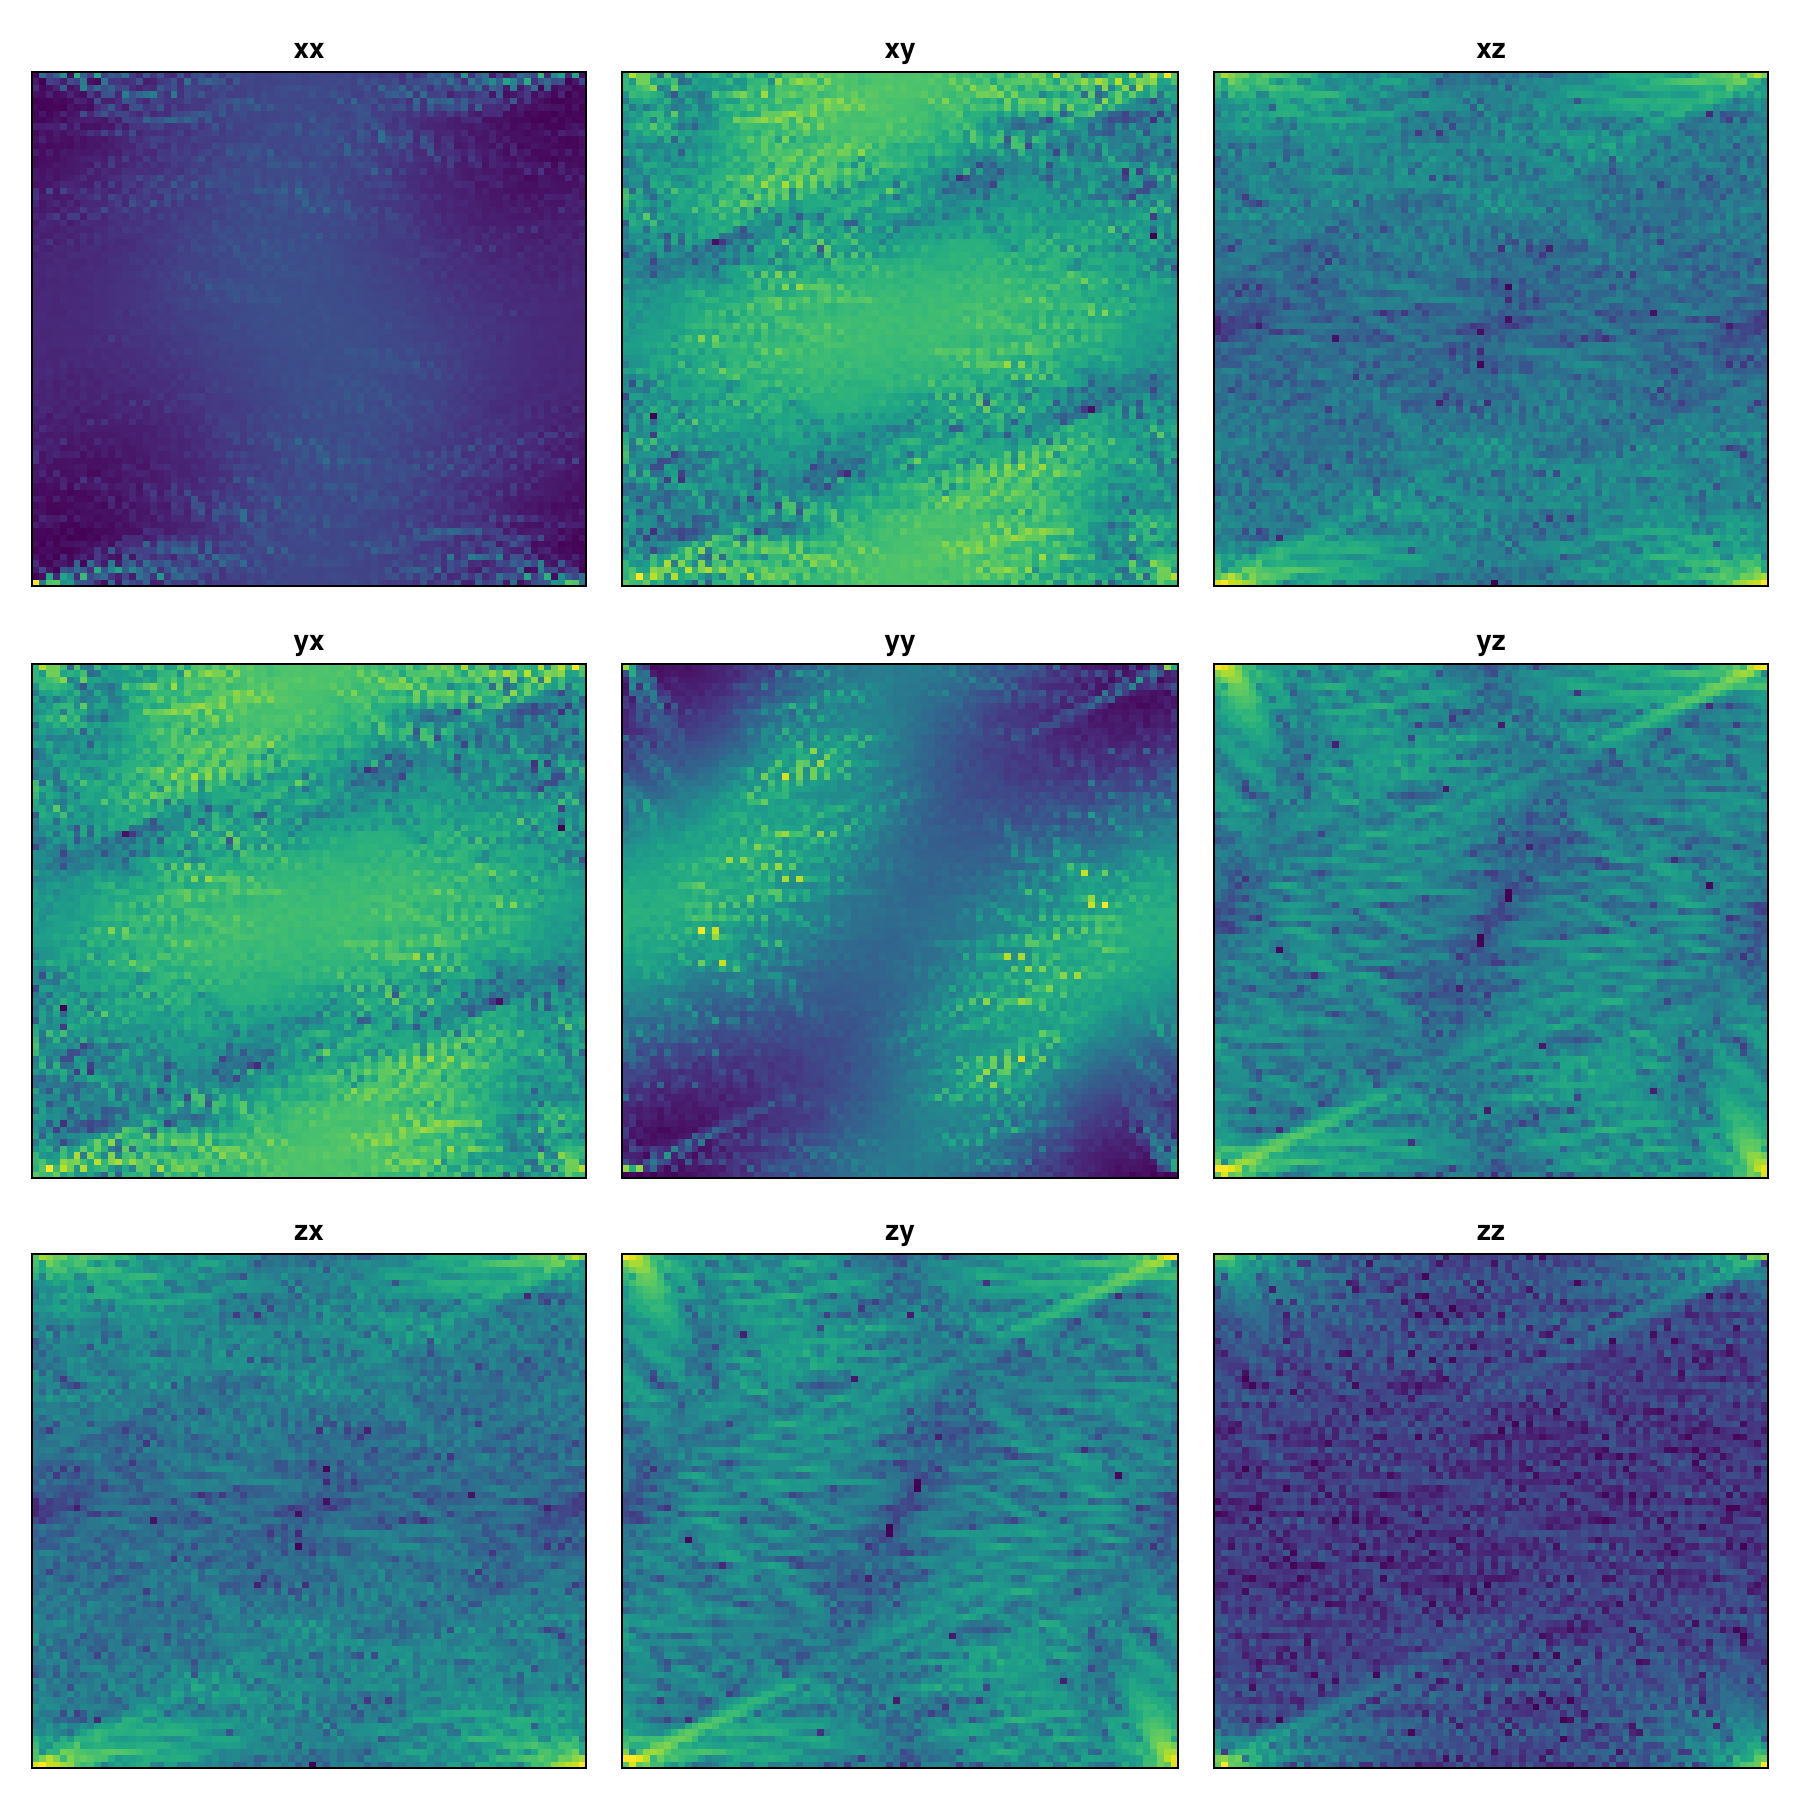

In [71]:
CairoMakie.activate!()

i = 30
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
scale = ReversibleScale(log)
corr_matrices = eachslice(etak_corrs[i], dims=(1, 2))
max_corrs = maximum(abs.(etak_corrs[i]))
min_corrs = minimum(abs.(etak_corrs[i]))
for x in 1:3
    for y in 1:3
        fig[x, y] = ax = Axis(fig, title="$(labels[x])$(labels[y])")
        corrs = getindex.(corr_matrices, x, y)
        heatmap!(ax, getfield.(abs.(corrs), :val), colorscale=scale)
        hidedecorations!(ax)
    end
end

print("Maximum correlation norm: $max_corrs")
fig

In [72]:
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
Ts = anneal_results[:T]
Ls = anneal_results[:Lx]
scale = ReversibleScale(log)

axs = Matrix{Axis}(undef, 3, 3)
for x in 1:3
    for y in 1:3
        fig[x, y] = axs[x, y] = Axis(fig, title="$(labels[x])$(labels[y])", yscale=scale)
    end
end

is = [29, 35, 37]
for (x, y) in Iterators.product(1:3, 1:3)
    ax = axs[x, y]

    corr_matrices = anneal_results["ηk_$(labels[x])$(labels[y])"]
    path, M_pos, K_pos = gen_path(size(corr_matrices[first(is)])...)
    all_corrs = [abs(corr_matrices[i][I...]) for I in path for i in is]
    min_corr = minimum(getfield.(all_corrs, :val))
    min_border = 0.9 * min_corr
    max_corr = maximum(getfield.(all_corrs, :val) + getfield.(all_corrs, :err))
    max_border = 1.1 * max_corr
    lines!(
        ax, [(1, max_border), (1, min_border)],
        color=:black, label="Γ", linestyle=:dash
    )
    lines!(
        ax, [(M_pos, max_border), (M_pos, min_border)],
        color=:red, label="M", linestyle=:dash
    )
    lines!(
        ax, [(K_pos, max_border), (K_pos, min_border)],
        color=:orange, label="K", linestyle=:dash
    )

    for i in is
        corr_matrix = corr_matrices[i]
        corrs = [corr_matrix[I...] for I in path]
        corr_vals = getfield.(abs.(corrs), :val)
        corr_errs = getfield.(abs.(corrs), :err)
        scatter!(ax, corr_vals, label="T=$(Ts[i])")
        lines!(ax, corr_vals)
        errorbars!(ax, 1:length(corr_vals), corr_vals, corr_errs)
    end
    ylims!(ax, (min_border, max_border))
end

Legend(fig[:, 4], axs[1, 1])
fig

## Annealed Bias Field

In [45]:
bias_results = JobResult("../jobs", "fm-bias")
separate_etaks!(bias_results.data)
transform!(bias_results.data, :spink_corrs => (v -> get_M_point.(v)) => :spink_M)
bias_results

JobResult("../jobs", "fm-bias", 11×40 DataFrame
 Row │ ηz               T        init_T   etak_corrs                         _ ⋯
     │ Measurem…        Float64  Float64  Array…                             M ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.777003±9.9e-6      0.5     10.0  Complex{Measurement{Float64}}[1.…  0 ⋯
   2 │ 0.989553±8.4e-6      0.5     10.0  Complex{Measurement{Float64}}[9.…  0
   3 │ 0.989546±7.9e-6      0.5     10.0  Complex{Measurement{Float64}}[1.…  0
   4 │ 0.989534±9.0e-6      0.5     10.0  Complex{Measurement{Float64}}[1.…  0
   5 │ 0.98955±1.1e-5       0.5     10.0  Complex{Measurement{Float64}}[1.…  0 ⋯
   6 │ 0.989558±1.1e-5      0.5     10.0  Complex{Measurement{Float64}}[1.…  0
   7 │ 0.98954±7.5e-6       0.5     10.0  Complex{Measurement{Float64}}[9.…  0
   8 │ 0.989552±5.8e-6      0.5     10.0  Complex{Measurement{Float64}}[1.…  0
   9 │ 0.989538±8.9e-6      0.5     10.0  Complex{Measurement{Float64}}[1

In [46]:
bias_results[[:_ll_sweep_time, :_ll_measure_time]]

11×2 DataFrame
 Row │ _ll_sweep_time   _ll_measure_time 
     │ Measurement…     Measurement…     
─────┼───────────────────────────────────
   1 │ 0.006465±6.6e-5   0.001633±1.8e-5
   2 │ 0.006397±5.1e-5   0.001632±1.3e-5
   3 │ 0.006491±6.2e-5   0.001641±1.7e-5
   4 │ 0.006461±6.0e-5   0.001628±1.7e-5
   5 │ 0.006369±5.0e-5   0.001634±1.4e-5
   6 │ 0.006416±5.7e-5   0.001637±1.5e-5
   7 │ 0.006446±5.5e-5   0.001643±1.5e-5
   8 │ 0.006396±5.1e-5   0.001647±1.4e-5
   9 │ 0.006382±5.4e-5   0.001634±1.5e-5
  10 │ 0.006448±4.8e-5   0.001651±1.3e-5
  11 │ 0.006445±5.0e-5   0.001645±1.3e-5

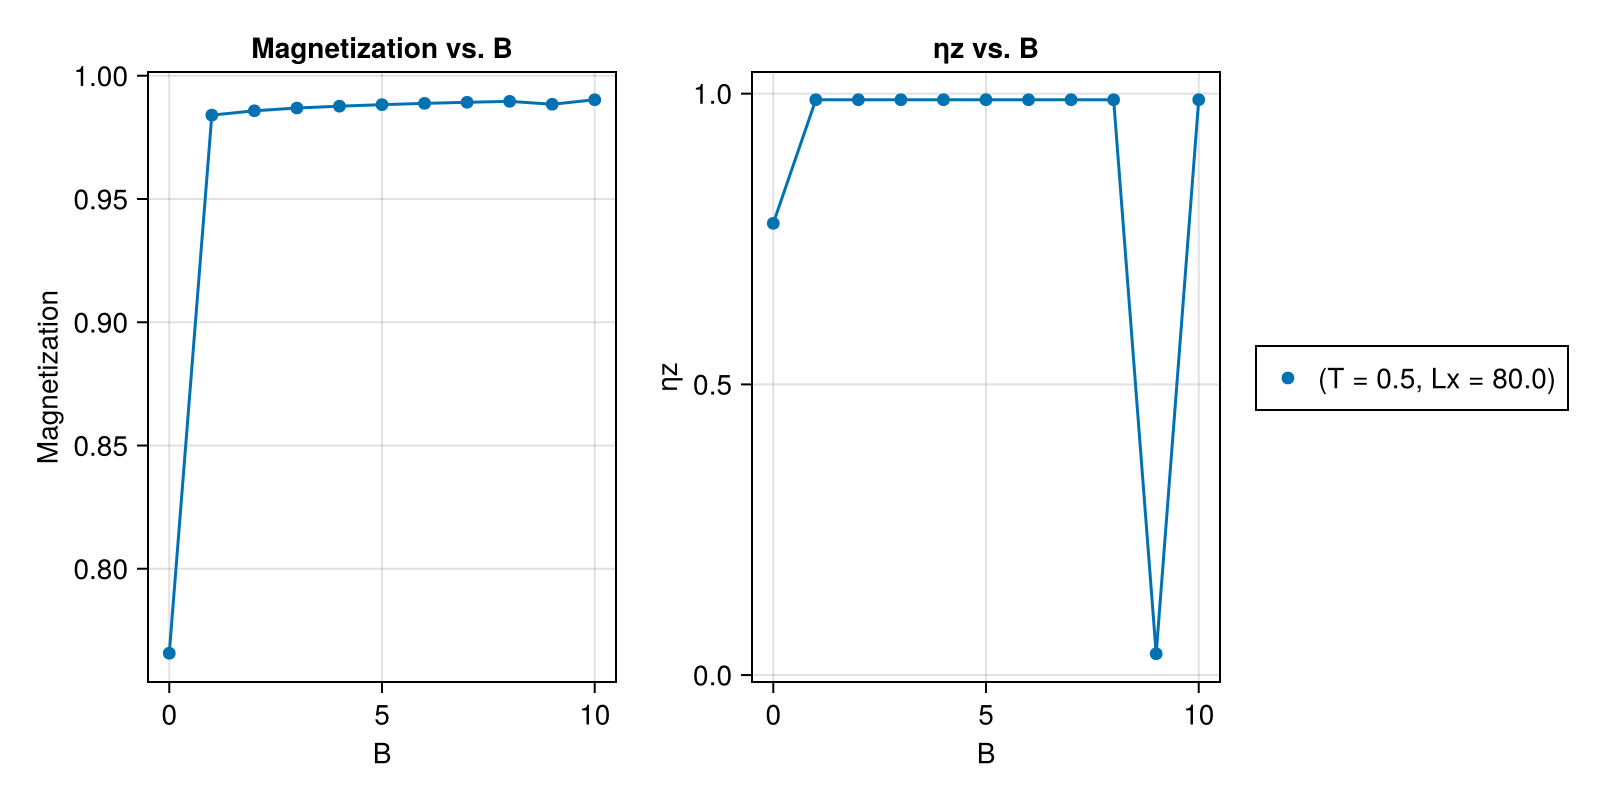

In [47]:
CairoMakie.activate!()

fig = Figure(size=(800, 400))
ax1 = fig[1,1] = Axis(fig, title="Magnetization vs. B", xlabel="B", ylabel="Magnetization")
# scatter!(ax1, bias_results[:B], M_points)
# lines!(ax1, bias_results[:B], M_points)
generate_plot!(ax1, :B, :Mag, [:T, :Lx], bias_results.data; line=true)
fig[1,2] = ax2 = Axis(fig, title="ηz vs. B", xlabel="B", ylabel="ηz")
generate_plot!(ax2, :B, :ηz, [:T, :Lx], bias_results.data; line=true)
Legend(fig[1,3], ax2)
fig

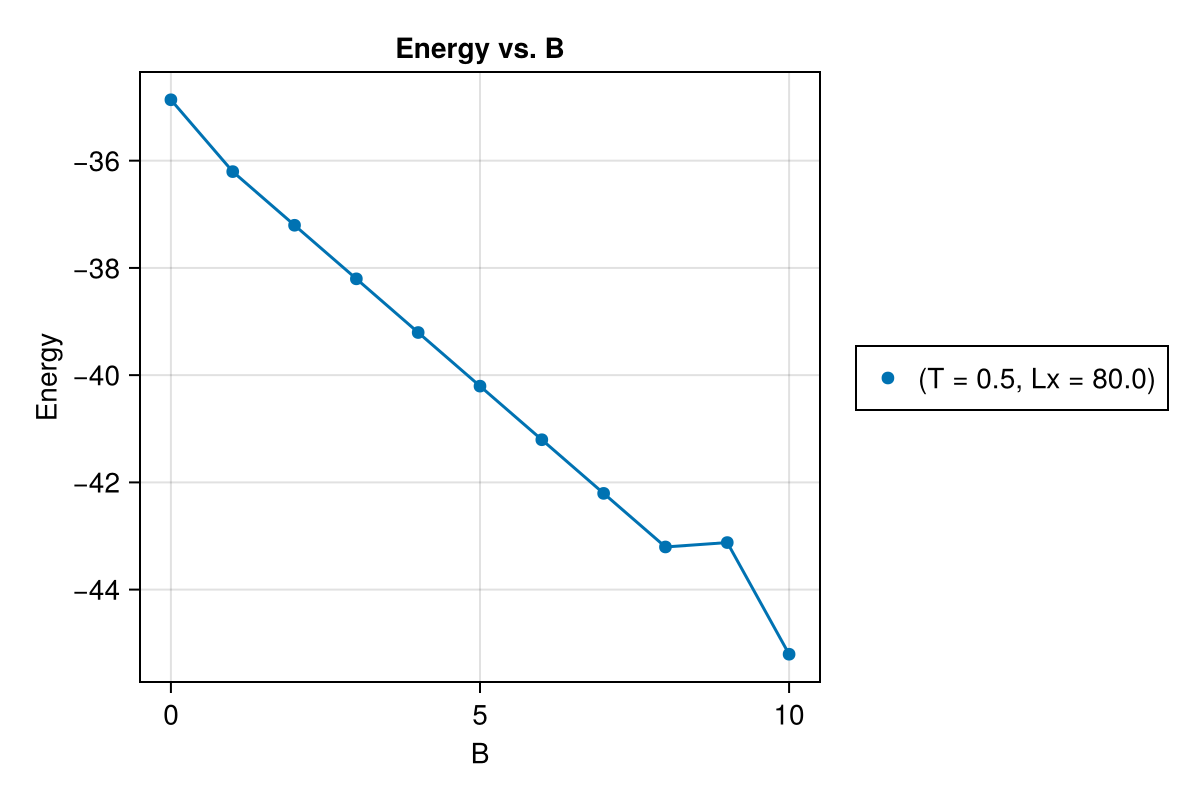

In [48]:
fig = Figure(size=(600, 400))
ax1 = fig[1,1] = Axis(fig, title="Energy vs. B", xlabel="B", ylabel="Energy")
# scatter!(ax1, bias_results[:B], M_points)
# lines!(ax1, bias_results[:B], M_points)
generate_plot!(ax1, :B, :Energy, [:T, :Lx], bias_results.data; line=true)
Legend(fig[1,2], ax1)
fig

In [58]:
bias_mctimes = get_mctime_data(bias_results, :etak_corrs, :ηz)
separate_etaks!.(bias_mctimes)
bias_mctimes

11-element Vector{DataFrame}:
 100×11 DataFrame
 Row │ etak_corrs                         ηz              ηk_xx                ⋯
     │ SubArray…                          SubArray…       Array…               ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ ComplexF64[1.44406e-6+0.0im 1.18…  fill(0.77699)   ComplexF64[1.44406e- ⋯
   2 │ ComplexF64[1.79423e-6+0.0im 1.02…  fill(0.777062)  ComplexF64[1.79423e-
   3 │ ComplexF64[1.40578e-6+0.0im 9.55…  fill(0.776981)  ComplexF64[1.40578e-
   4 │ ComplexF64[1.1079e-6+0.0im 1.546…  fill(0.776984)  ComplexF64[1.1079e-6
   5 │ ComplexF64[5.98299e-7+0.0im 1.16…  fill(0.777107)  ComplexF64[5.98299e- ⋯
   6 │ ComplexF64[6.7577e-7+0.0im 1.024…  fill(0.776942)  ComplexF64[6.7577e-7
   7 │ ComplexF64[1.86733e-6+0.0im 8.51…  fill(0.776959)  ComplexF64[1.86733e-
   8 │ ComplexF64[1.16968e-6+0.0im 1.12…  fill(0.777043)  ComplexF64[1.16968e-
  ⋮  │                 ⋮                        ⋮                        

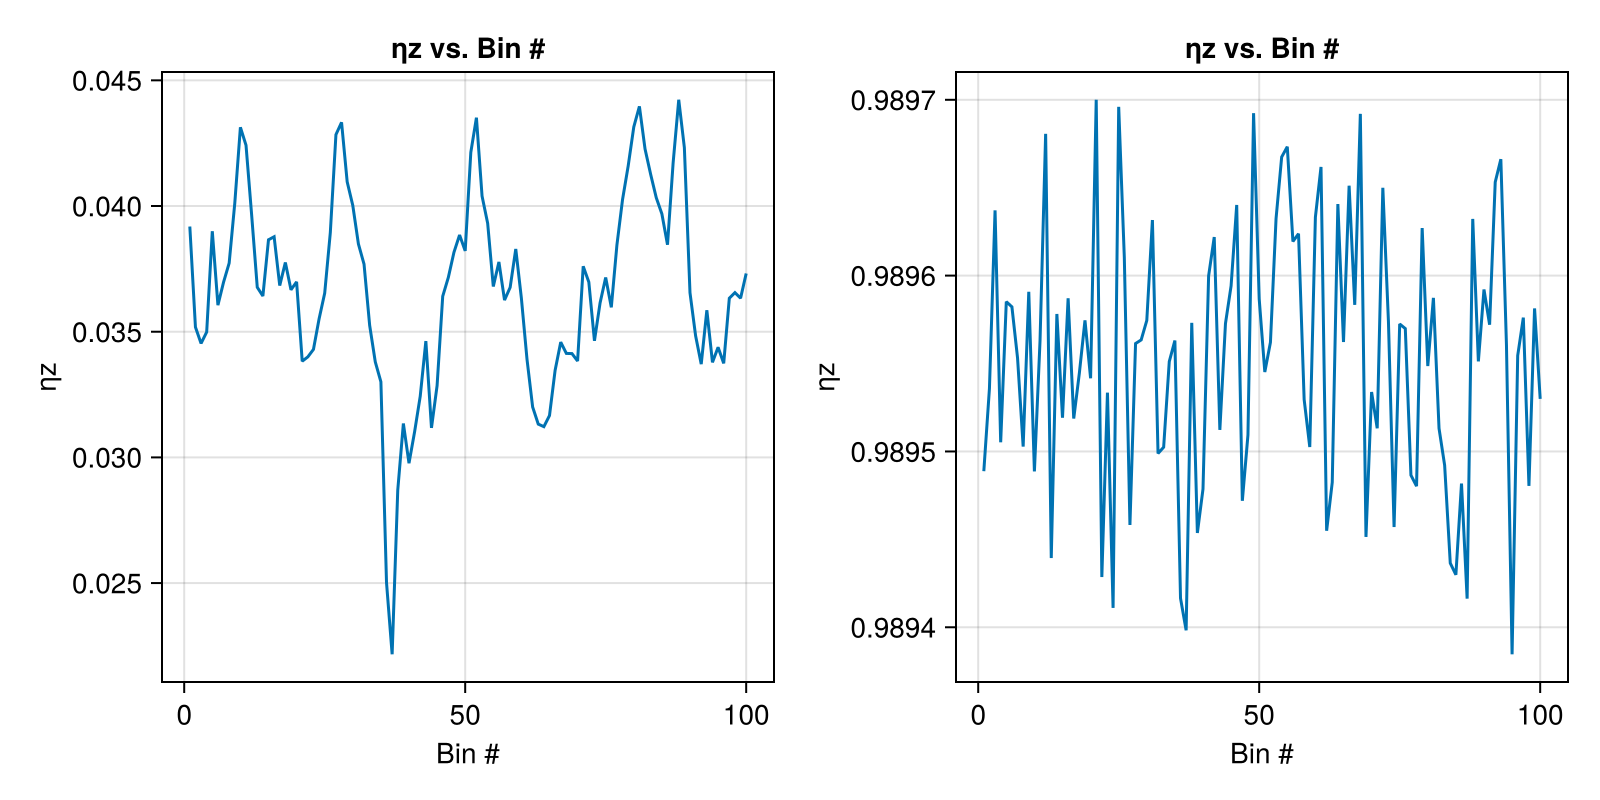

In [65]:
CairoMakie.activate!()
i = 10
k_pos = (1, 1)

var1 = :ηz
var2 = :ηz
fig = Figure(size=(800, 400))
fig[1,1] = ax1 = Axis(fig, title="$var1 vs. Bin #", xlabel="Bin #", ylabel="$var1")
fig[1,2] = ax2 = Axis(fig, title="$var2 vs. Bin #", xlabel="Bin #", ylabel="$var2")
lines!(ax1, abs.(first.(bias_mctimes[i][:, var1])))
lines!(ax2, abs.(first.(bias_mctimes[i+1][:, var2])))
fig

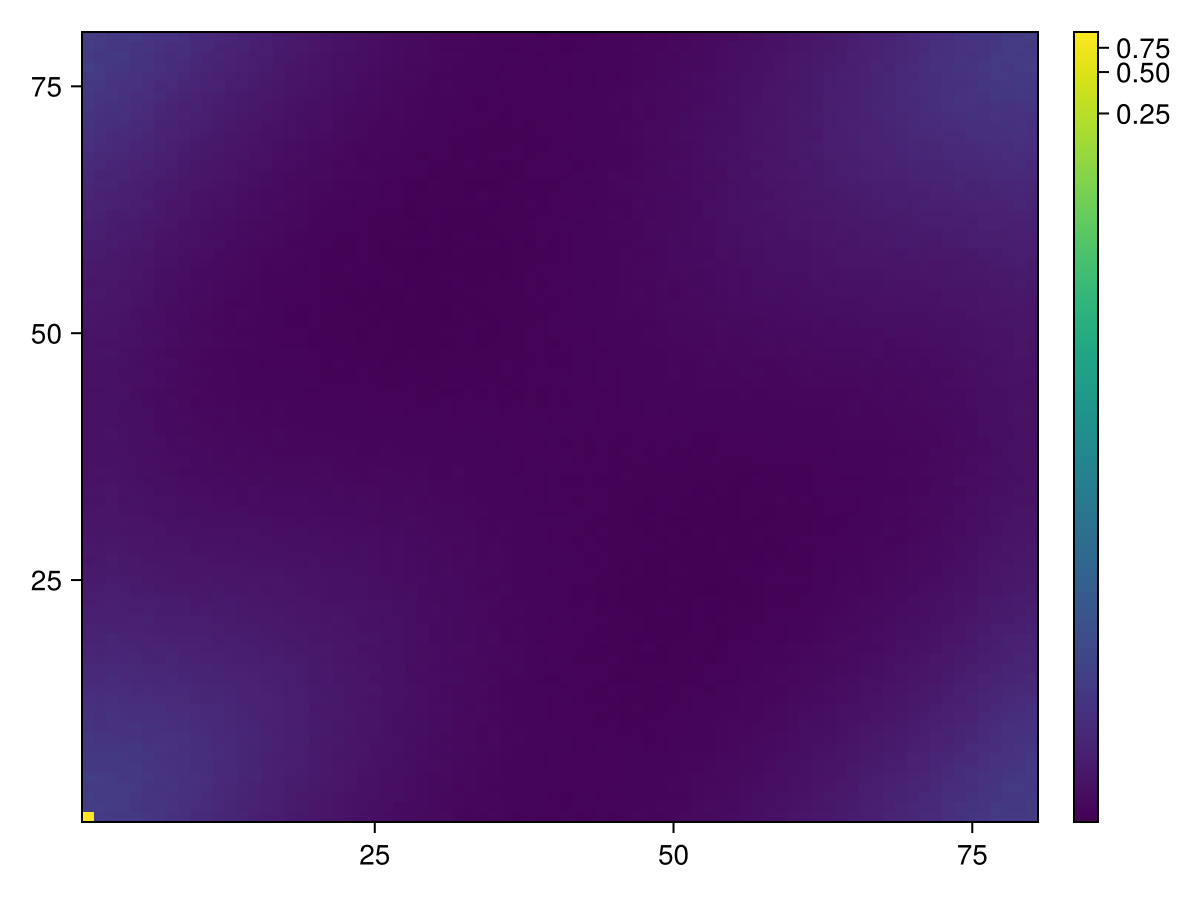

In [66]:
CairoMakie.activate!()
spink_corrs = bias_results[:spink_corrs]
fig = Figure(size=(500, 500))
ax = fig[1,1] = Axis(fig; title="Spin_k")
scale = ReversibleScale(log)
fig, ax, hm = heatmap(getfield.(spink_corrs[10], :val), colorscale=scale)
Colorbar(fig[1, 2], hm)
fig

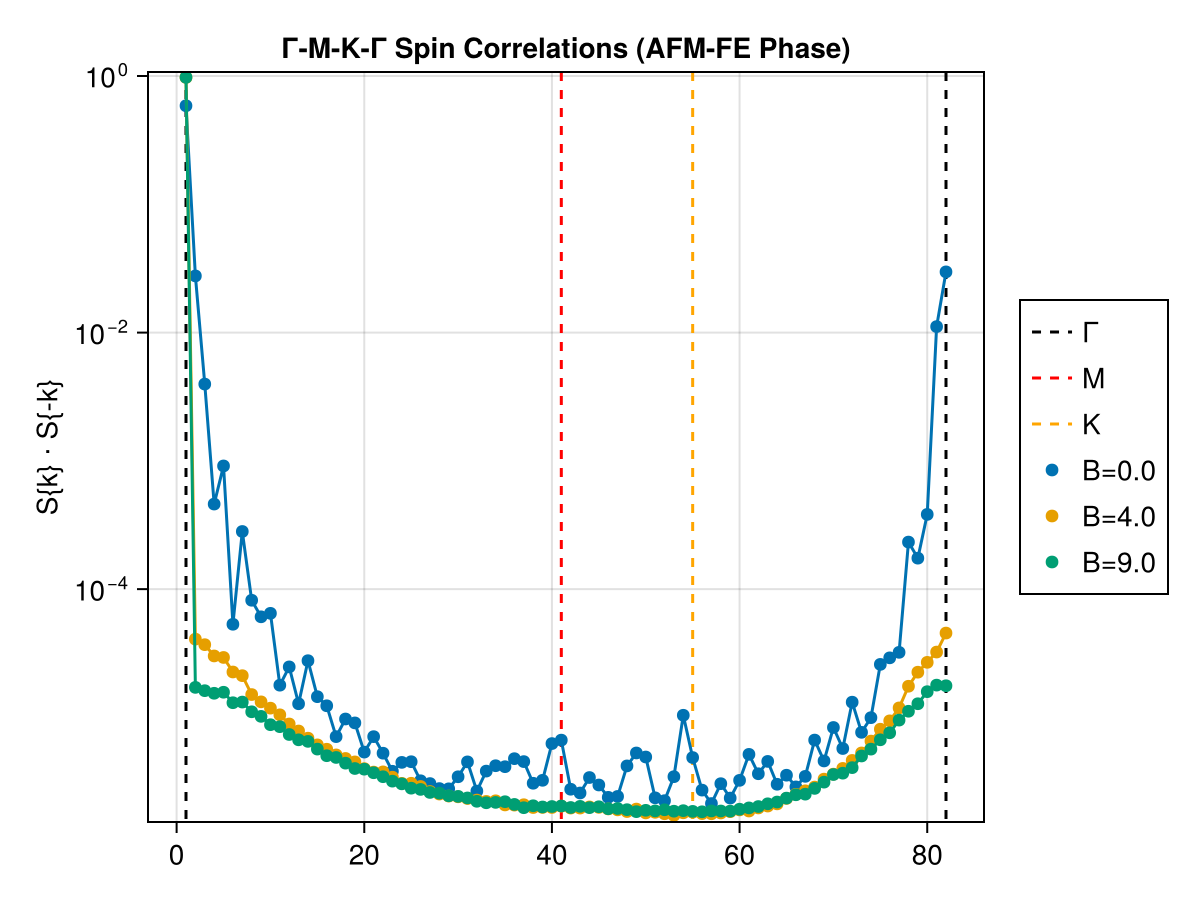

In [67]:
CairoMakie.activate!()
spink_corrs = bias_results[:spink_corrs]
is = [1, 5, 10]

spink_corrs = bias_results[:spink_corrs]
Bs = bias_results[:B]
path, M_pos, K_pos = gen_path(size(spink_corrs[1])...)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (AFM-FE Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

all_corrs = [spink_corrs[i][I...] for I in path for i in is]
min_corr = minimum(getfield.(all_corrs, :val) - getfield.(all_corrs, :err))
min_border = 0.9 * min_corr
max_corr = maximum(getfield.(all_corrs, :val) + getfield.(all_corrs, :err))
max_border = 1.1 * max_corr
lines!([(1, max_border), (1, min_border)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, max_border), (M_pos, min_border)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, max_border), (K_pos, min_border)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), max_border), (length(path), min_border)], color=:black, linestyle=:dash)

for i in is
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs, label="B=$(Bs[i])")
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (min_border, max_border))
Legend(fig[1,2], ax)
fig

Any[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (79, 40), (77, 39), (75, 38), (73, 37), (71, 36), (69, 35), (67, 34), (65, 33), (63, 32), (61, 31), (59, 30), (57, 29), (55, 28), (53, 27), (54, 26), (55, 25), (56, 24), (57, 23), (58, 22), (59, 21), (60, 20), (61, 19), (62, 18), (63, 17), (64, 16), (65, 15), (66, 14), (67, 13), (68, 12), (69, 11), (70, 10), (71, 9), (72, 8), (73, 7), (74, 6), (75, 5), (76, 4), (77, 3), (78, 2), (79, 1)]


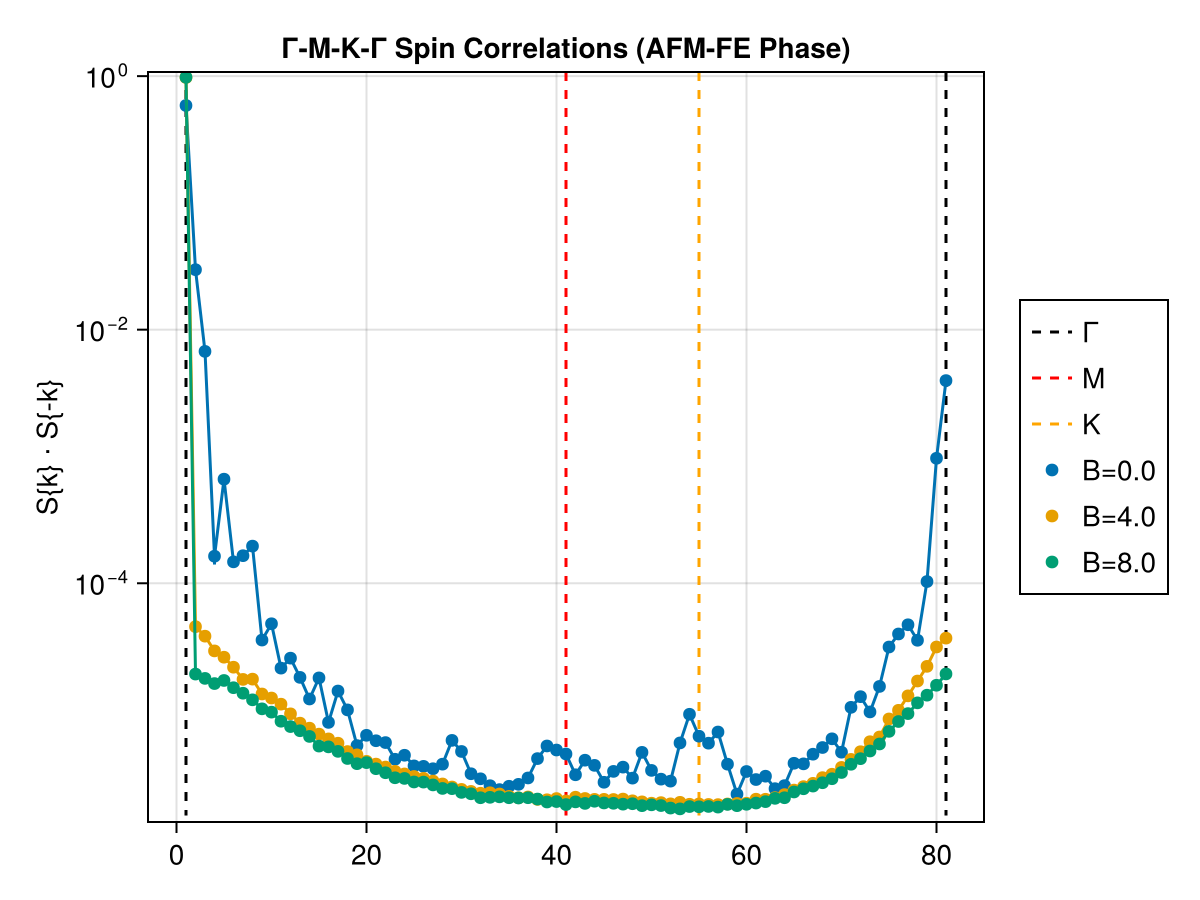

In [53]:
CairoMakie.activate!()
Lx, Ly = size(spink_corrs[1])

path = []
pos = (1, 1)
push!(path, pos)
while pos[2] < div(Ly, 2) + 1
    pos = pos .+ (0, 1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
M_pos = length(path)
while pos[2] > div(Ly, 3) + 1
    pos = pos .+ (-2, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
K_pos = length(path)
while pos[2] > 1
    pos = pos .+ (1, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
println(path)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (AFM-FE Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

all_corrs = [spink_corrs[i][I...] for I in path for i in is]
min_corr = minimum(getfield.(all_corrs, :val) - getfield.(all_corrs, :err))
min_border = 0.9 * min_corr
max_corr = maximum(getfield.(all_corrs, :val) + getfield.(all_corrs, :err))
max_border = 1.1 * max_corr
lines!([(1, max_border), (1, min_border)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, max_border), (M_pos, min_border)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, max_border), (K_pos, min_border)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), max_border), (length(path), min_border)], color=:black, linestyle=:dash)

for i in is
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs, label="B=$(Bs[i])")
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (0.8 * min_corr, 1.1 * max_corr))
Legend(fig[1,2], ax)
fig

Any[(1, 1), (80, 80), (79, 79), (78, 78), (77, 77), (76, 76), (75, 75), (74, 74), (73, 73), (72, 72), (71, 71), (70, 70), (69, 69), (68, 68), (67, 67), (66, 66), (65, 65), (64, 64), (63, 63), (62, 62), (61, 61), (60, 60), (59, 59), (58, 58), (57, 57), (56, 56), (55, 55), (54, 54), (53, 53), (52, 52), (51, 51), (50, 50), (49, 49), (48, 48), (47, 47), (46, 46), (45, 45), (44, 44), (43, 43), (42, 42), (41, 41), (42, 40), (43, 39), (44, 38), (45, 37), (46, 36), (47, 35), (48, 34), (49, 33), (50, 32), (51, 31), (52, 30), (53, 29), (54, 28), (55, 27), (56, 29), (57, 31), (58, 33), (59, 35), (60, 37), (61, 39), (62, 41), (63, 43), (64, 45), (65, 47), (66, 49), (67, 51), (68, 53), (69, 55), (70, 57), (71, 59), (72, 61), (73, 63), (74, 65), (75, 67), (76, 69), (77, 71), (78, 73), (79, 75), (80, 77), (1, 79), (2, 1)]


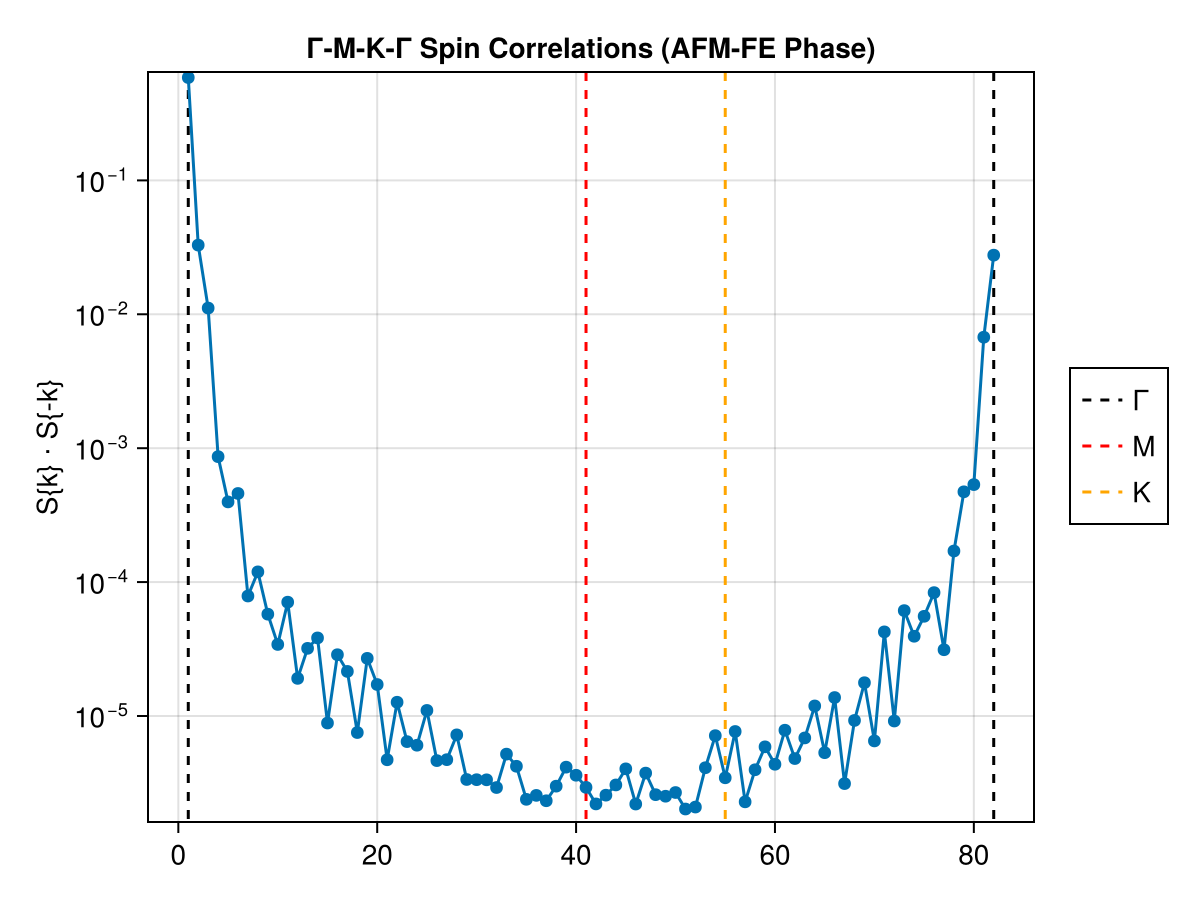

In [54]:
CairoMakie.activate!()
Lx, Ly = size(spink_corrs[1])

path = []
pos = (1, 1)
push!(path, pos)
while pos[2] > -div(Ly, 2) + 1
    pos = pos .+ (-1, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
M_pos = length(path)
while pos[1] < -div(Lx, 3) + 1
    pos = pos .+ (1, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
K_pos = length(path)
while pos[2] < 1
    pos = pos .+ (1, 2)
    push!(path, mod1.(pos, (Lx, Ly)))
end
println(path)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (AFM-FE Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

min_corr = minimum(getfield.([spink_corrs[1][I...] for I in path], :val))
max_corr = maximum(getfield.([spink_corrs[1][I...] for I in path], :val))
lines!([(1, 2), (1, 1e-9)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, 2), (M_pos, 1e-9)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, 2), (K_pos, 1e-9)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), 2), (length(path), 1e-9)], color=:black, linestyle=:dash)

for i in [1]
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs)
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (0.8 * min_corr, 1.1 * max_corr))
Legend(fig[1,2], ax)
fig

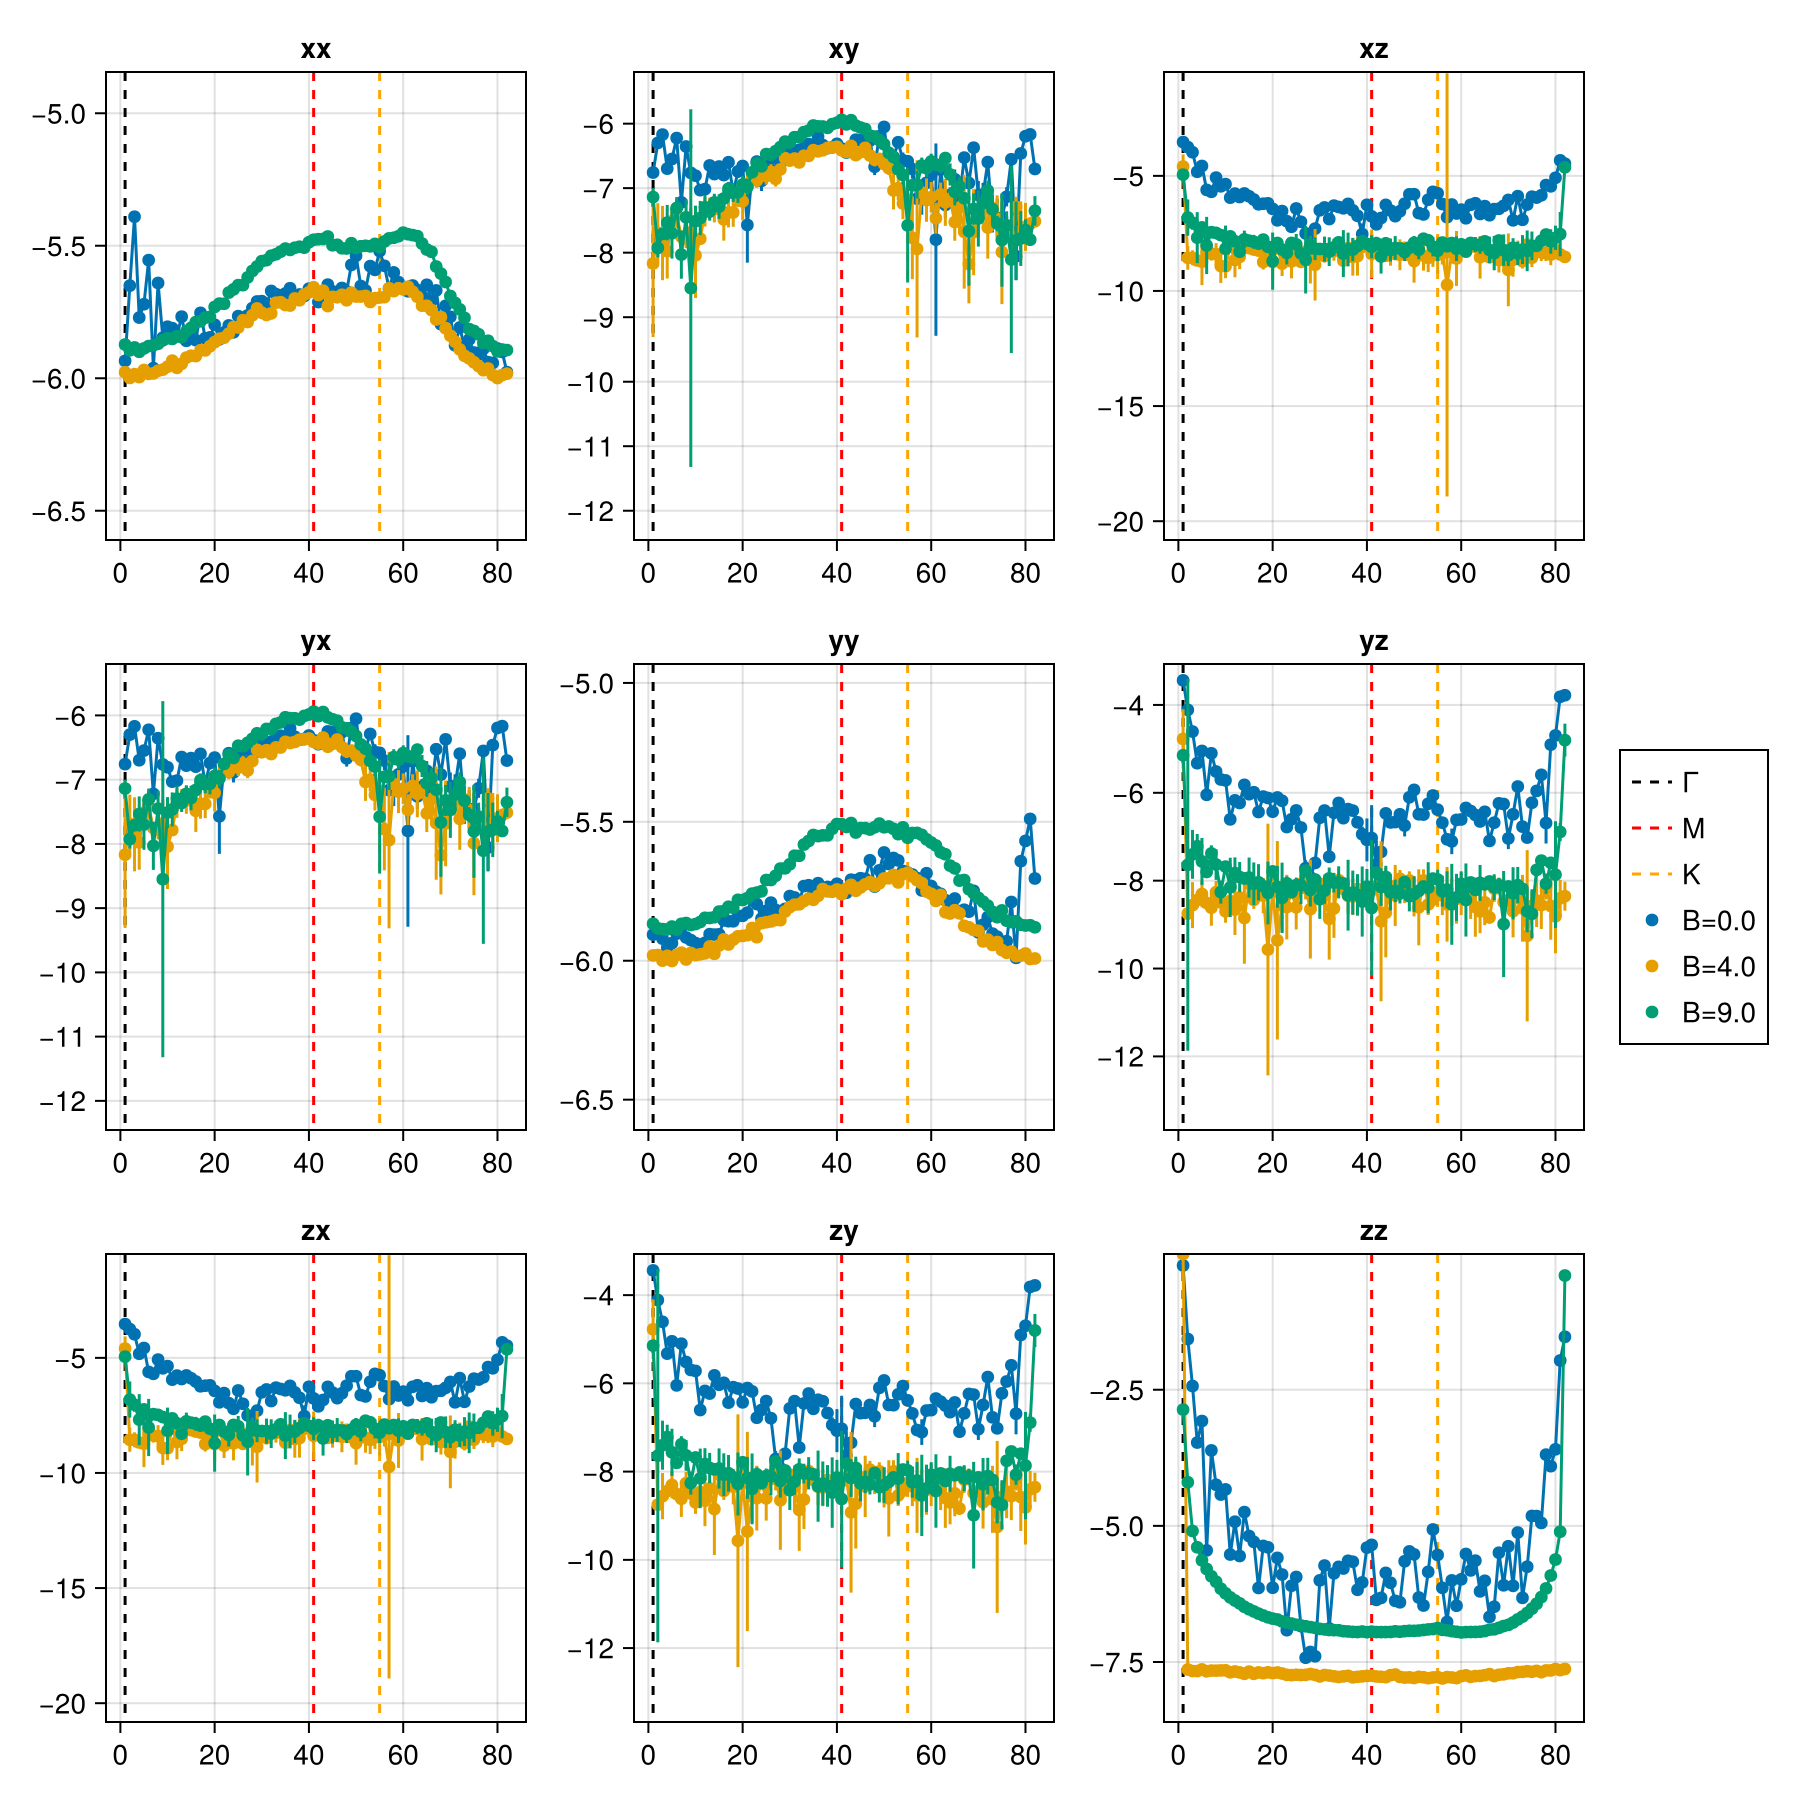

In [70]:
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
Bs = bias_results[:B]

axs = Matrix{Axis}(undef, 3, 3)
for x in 1:3
    for y in 1:3
        fig[x, y] = axs[x, y] = Axis(fig, title="$(labels[x])$(labels[y])")
    end
end

is = [1, 5, 10]
for (x, y) in Iterators.product(1:3, 1:3)
    ax = axs[x, y]

    corr_matrices = bias_results["ηk_$(labels[x])$(labels[y])"]
    path, M_pos, K_pos = gen_path(size(corr_matrices[first(is)])...)
    all_corrs = log10.([abs(corr_matrices[i][I...]) for I in path for i in is])
    min_corr = minimum(getfield.(all_corrs, :val) - getfield.(all_corrs, :err))
    min_border = 1.1 * min_corr
    max_corr = maximum(getfield.(all_corrs, :val) + getfield.(all_corrs, :err))
    max_border = 0.9 * max_corr
    lines!(
        ax, [(1, max_border), (1, min_border)],
        color=:black, label="Γ", linestyle=:dash
    )
    lines!(
        ax, [(M_pos, max_border), (M_pos, min_border)],
        color=:red, label="M", linestyle=:dash
    )
    lines!(
        ax, [(K_pos, max_border), (K_pos, min_border)],
        color=:orange, label="K", linestyle=:dash
    )

    for i in is
        corr_matrix = corr_matrices[i]
        corrs = log10.(abs.([corr_matrix[I...] for I in path]))
        corr_vals = getfield.(corrs, :val)
        corr_errs = getfield.(corrs, :err)
        scatter!(ax, corr_vals, label="B=$(Bs[i])")
        lines!(ax, corr_vals)
        errorbars!(ax, 1:length(corr_vals), corr_vals, corr_errs)
    end
    ylims!(ax, (min_border, max_border))
end

Legend(fig[:, 4], axs[1, 1])
fig